# Adaptive and Gradient Boosting

In this notebook, we demonstrate the use of AdaBoost and gradient boosting, incuding several state-of-the-art implementations of this very powerful and flexible algorithm that greatly speed up training. 

We use the stock return dataset with a few engineered factors created in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature_engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb).

## Imports and Settings

In [76]:
%matplotlib inline

import sys, os
import warnings
from time import time
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.inspection.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [77]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time

In [78]:
results_path = Path('results')
if not results_path.exists():
    results_path.mkdir(exist_ok=True)

In [79]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

## Prepare Data

### Get source

We use the `engineered_features` dataset created in [Chapter 4, Alpha Factor Research](../04_alpha_factor_research)

Set data store location:

In [80]:
DATA_STORE = '../data/assets.h5'

In [81]:
def get_data(start='2000', end='2018', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()
        
    y = (df[target]>0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

### Factorize Categories

Define columns with categorical data:

In [82]:
cat_cols = ['year', 'month', 'age', 'msize', 'sector']

Integer-encode categorical columns:

In [83]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1)
    return df

### One-Hot Encoding

Create dummy variables from categorical columns if needed:

In [84]:
def get_one_hot_data(df, cols=cat_cols[:-1]):
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '') for c in df.columns})

### Get Holdout Set

Create holdout test set to estimate generalization error after cross-validation:

In [85]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

## Load Data

The algorithms in this chapter use a dataset generated in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature-engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb) that needs to be executed first.

In [86]:
y, features = get_data()
X_dummies = get_one_hot_data(features)
X_factors = factorize_cats(features)

In [87]:
y_clean, features_clean = get_data(dropna=True)
X_dummies_clean = get_one_hot_data(features_clean)
X_factors_clean = factorize_cats(features_clean)

## Cross-Validation Setup

### Custom Time Series KFold Generator

Custom Time Series KFold generator introduced in [Chapter 11](../11_decision_trees_random_forests) on [Decision Trees and Random Forests](../11_decision_trees_random_forests/01_decision_trees.ipynb#custom_kfold).

In [88]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [89]:
cv = OneStepTimeSeriesSplit(n_splits=12, 
                            test_period_length=1, 
                            shuffle=False)

In [90]:
run_time = {}

### CV Metrics

Define some metrics for use with cross-validation:

In [91]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

Helper function that runs cross-validation for the various algorithms.

In [152]:
def run_cv(clf, X=X_dummies, y=y, metrics=metrics, cv=cv, fit_params=None):
    start = time()
    scores = cross_validate(estimator=clf,
                          X=X,
                          y=y,
                          scoring=list(metrics.keys()),
                          cv=cv,
                          return_train_score=True,
                          n_jobs=1,
                          verbose=1,
                          fit_params=fit_params)
    duration = time() - start
    return scores, duration

### CV Result Handler Functions

The following helper functions manipulate and plot the cross-validation results to produce the outputs below.

In [93]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [94]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300);

## Baseline Classifier

`sklearn` provides the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) that makes predictions using simple rule and is useful as a simple baseline to compare with the other (real) classifiers we use below.

The `stratified` rule generates predictions based on the training set’s class distribution, i.e. always predicts the most frequent class.

In [95]:
dummy_clf = DummyClassifier(strategy='stratified',
                            random_state=42)

In [96]:
algo = 'dummy_clf'

In [97]:
fname = f'results/{algo}_cv_result.joblib'
if not Path(fname).exists():
    dummy_cv_result, run_time[algo] = run_cv(dummy_clf)
    joblib.dump(dummy_cv_result, fname)
else:
    dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    3.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.1s finished


Unsurprisingly, it produces results near the AUC threshold for arbitrary predictions of 0.5:

In [98]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.499775,0.499975
Accuracy,0.499775,0.499975
F1,0.512867,0.504873
Log Loss,-17.204103,-17.102904
Precision,0.545199,0.504921
Recall,0.501896,0.504826


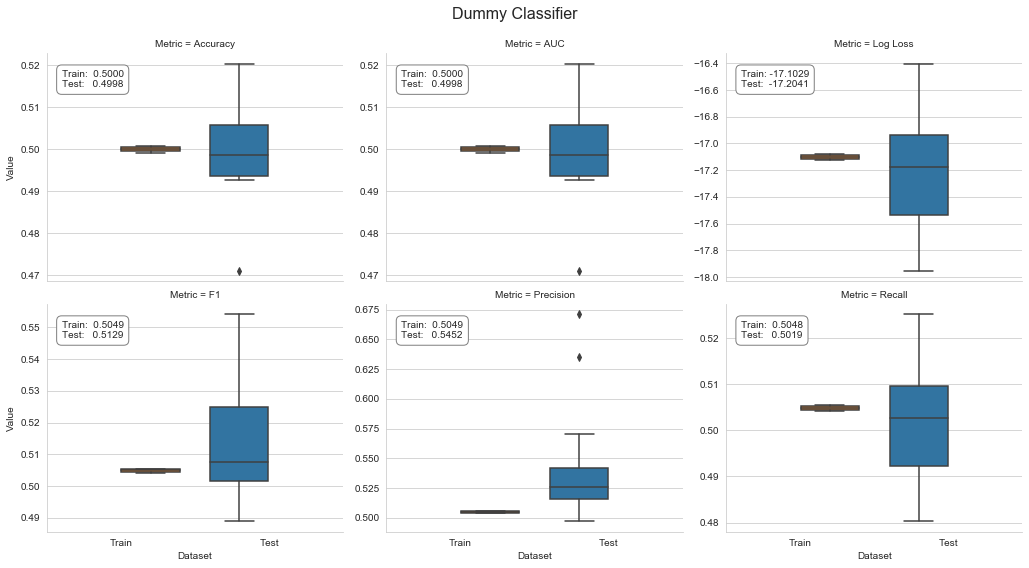

In [99]:
plot_result(dummy_result, model='Dummy Classifier')

## RandomForest

For comparison, we train a `RandomForestClassifier` as presented in [Chapter 11 on Decision Trees and Random Forests](../11_decision_trees_random_forests/02_random_forest.ipynb).

### Configure

In [100]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

### Cross-validate

In [101]:
algo = 'random_forest'

In [102]:
fname = f'results/{algo}_cv_result.joblib'
if not Path(fname).exists():
    rf_cv_result, run_time[algo] = run_cv(rf_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(rf_cv_result, fname)
else:
    rf_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  7.7min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  7.7min finished


### Plot Results

In [103]:
rf_result = stack_results(rf_cv_result)
rf_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.535827,1.00000
Accuracy,0.517894,1.00000
F1,0.511238,1.00000
Log Loss,-0.688548,-0.16917
Precision,0.569978,1.00000
Recall,0.545110,1.00000


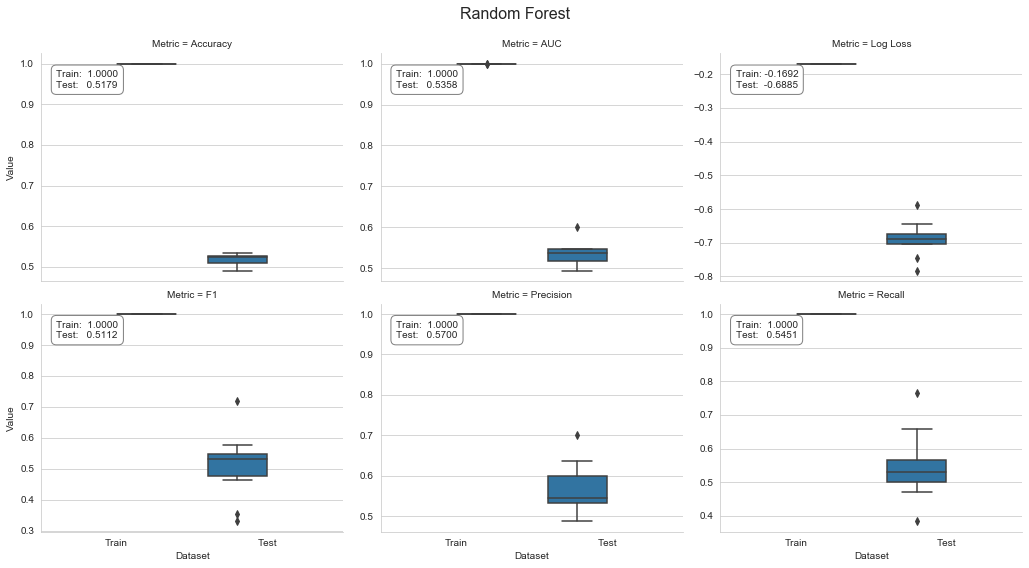

In [104]:
plot_result(rf_result, model='Random Forest', )

## sklearn: AdaBoost

As part of its [ensemble module](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), sklearn provides an [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) implementation that supports two or more classes. The code examples for this section are in the notebook gbm_baseline that compares the performance of various algorithms with a dummy classifier that always predicts the most frequent class.

### Base Estimator

We need to first define a base_estimator as a template for all ensemble members and then configure the ensemble itself. We'll use the default DecisionTreeClassifier with max_depth=1—that is, a stump with a single split. The complexity of the base_estimator is a key tuning parameter because it depends on the nature of the data. 

As demonstrated in the [previous chapter](../../10_decision_trees_random_forests), changes to `max_depth` should be combined with appropriate regularization constraints using adjustments to, for example, `min_samples_split`:

In [105]:
base_estimator = DecisionTreeClassifier(criterion='gini', 
                                        splitter='best',
                                        max_depth=1, 
                                        min_samples_split=2, 
                                        min_samples_leaf=20, 
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None, 
                                        random_state=None, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        min_impurity_split=None, 
                                        class_weight=None)

### AdaBoost Configuration

In the second step, we'll design the ensemble. The n_estimators parameter controls the number of weak learners and the learning_rate determines the contribution of each weak learner, as shown in the following code. By default, weak learners are decision tree stumps:

In [106]:
ada_clf = AdaBoostClassifier(base_estimator=base_estimator,
                             n_estimators=100,
                             learning_rate=1.0,
                             algorithm='SAMME.R',
                             random_state=42)

The main tuning parameters that are responsible for good results are `n_estimators` and the base estimator complexity because the depth of the tree controls the extent of the interaction among the features. 

### Cross-validate

We will cross-validate the AdaBoost ensemble using a custom 12-fold rolling time-series split to predict 1 month ahead for the last 12 months in the sample, using all available prior data for training, as shown in the following code:

In [107]:
algo = 'adaboost'

In [108]:
fname = f'results/{algo}_cv_result.joblib'
if not Path(fname).exists():
    ada_cv_result, run_time[algo] = run_cv(ada_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(ada_cv_result, fname)
else:
    ada_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  6.1min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.1min finished


### Plot Result

In [109]:
ada_result = stack_results(ada_cv_result)
ada_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.534758,0.609424
Accuracy,0.506772,0.569118
F1,0.466868,0.571264
Log Loss,-0.692840,-0.692683
Precision,0.547130,0.583732
Recall,0.575898,0.588593


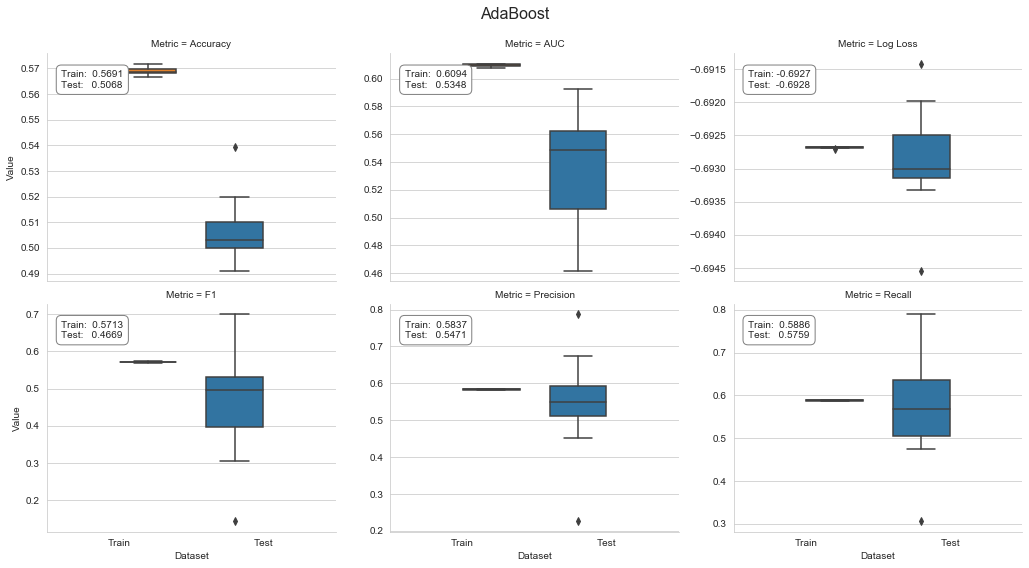

In [110]:
plot_result(ada_result, model='AdaBoost', fname=f'figures/{algo}_cv_result')

## GradientBoostingClassifier

The ensemble module of sklearn contains an implementation of gradient boosting trees for regression and classification, both binary and multiclass. 

### Configure

The following [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) initialization code illustrates the key tuning parameters that we previously introduced, in addition to those that we are familiar with from looking at standalone decision tree models.

The available loss functions include the exponential loss that leads to the AdaBoost algorithm and the deviance that corresponds to the logistic regression for probabilistic outputs. 

The `friedman_mse` node quality measure is a variation on the mean squared error that includes an improvement score (see GitHub references for links to original papers), as shown in the following code:

In [111]:
gb_clf = GradientBoostingClassifier(loss='deviance',                # deviance = logistic reg; exponential: AdaBoost
                                    learning_rate=0.1,              # shrinks the contribution of each tree
                                    n_estimators=100,               # number of boosting stages
                                    subsample=1.0,                  # fraction of samples used t fit base learners
                                    criterion='friedman_mse',       # measures the quality of a split
                                    min_samples_split=2,            
                                    min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0,   # min. fraction of sum of weights
                                    max_depth=3,                    # opt value depends on interaction
                                    min_impurity_decrease=0.0, 
                                    min_impurity_split=None, 
                                    init=None, 
                                    random_state=None, 
                                    max_features=None, 
                                    verbose=0, 
                                    max_leaf_nodes=None, 
                                    warm_start=False, 
                                    presort='auto', 
                                    validation_fraction=0.1, 
                                    n_iter_no_change=None, 
                                    tol=0.0001)

### Cross-validate

In [112]:
algo = 'sklearn_gbm'

In [113]:
fname = f'results/{algo}_cv_result.joblib'
if not Path(fname).exists():
    gb_cv_result, run_time[algo] = run_cv(gb_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(gb_cv_result, fname)
else:
    gb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 11.1min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 11.1min finished


### Plot Results

In [114]:
gb_result = stack_results(gb_cv_result)
gb_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.537317,0.695988
Accuracy,0.504663,0.626737
F1,0.464947,0.631249
Log Loss,-0.684333,-0.637253
Precision,0.548900,0.647229
Recall,0.576597,0.644734


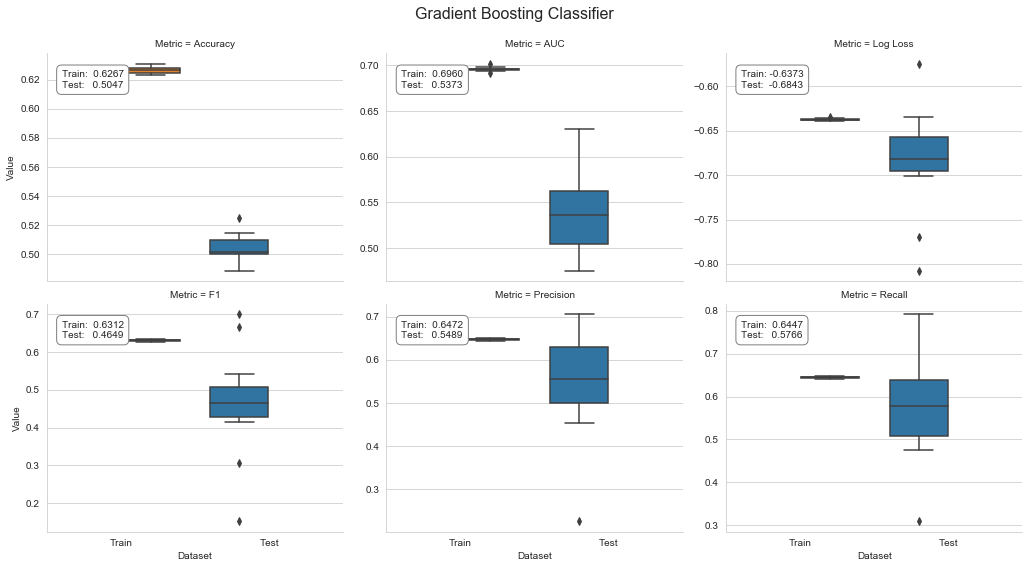

In [115]:
plot_result(gb_result, model='Gradient Boosting Classifier', fname=f'figures/{algo}_cv_result')

### Partial Dependence Plot

In [116]:
gb_clf.fit(y=y_clean, X=X_dummies_clean)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [117]:
# mean accuracy
gb_clf.score(X=X_dummies_clean, y=y_clean)

0.6413629653434026

In [118]:
y_score = gb_clf.predict_proba(X_dummies_clean)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_clean)

0.6930659625411465

#### Feature Importance

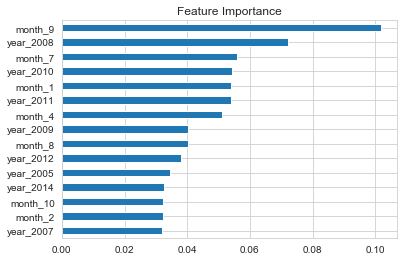

In [119]:
(pd.Series(gb_clf.feature_importances_, 
          index=X_dummies_clean.columns)
 .sort_values(ascending=False)
 .head(15)).sort_values().plot.barh(title='Feature Importance');

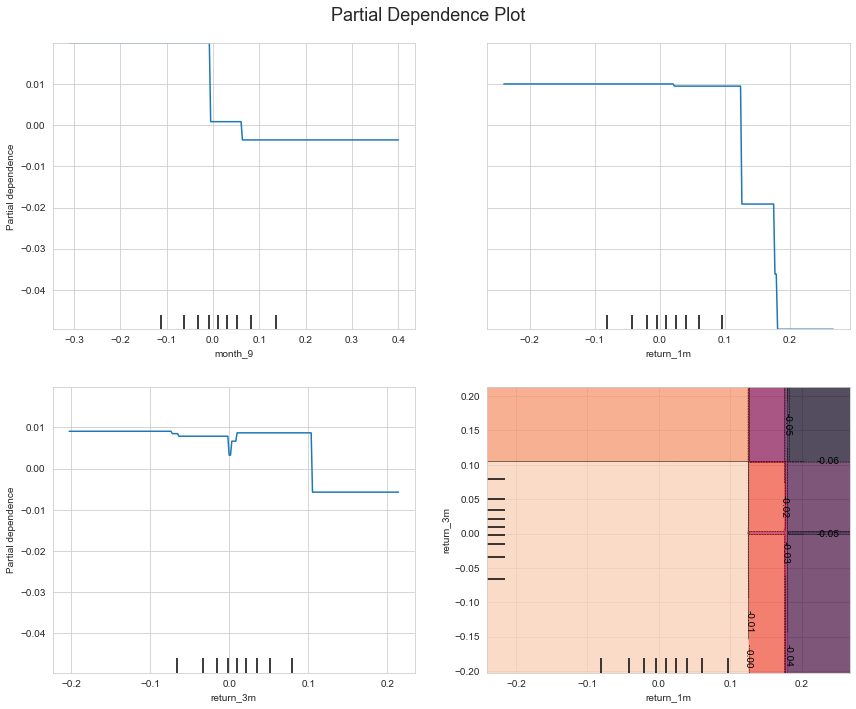

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
plot_partial_dependence(
    estimator=gb_clf,
    X=X_dummies_clean,
    features=['month_9', 'return_1m', 'return_3m', ('return_1m', 'return_3m')],
    feature_names=['month_9', 'return_1m', 'return_3m'],
    percentiles=(0.01, 0.99),
    n_jobs=-1,
    n_cols=2,
    grid_resolution=250,
    fig=fig,
    ax=axes)
fig.suptitle('Partial Dependence Plot', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.93)

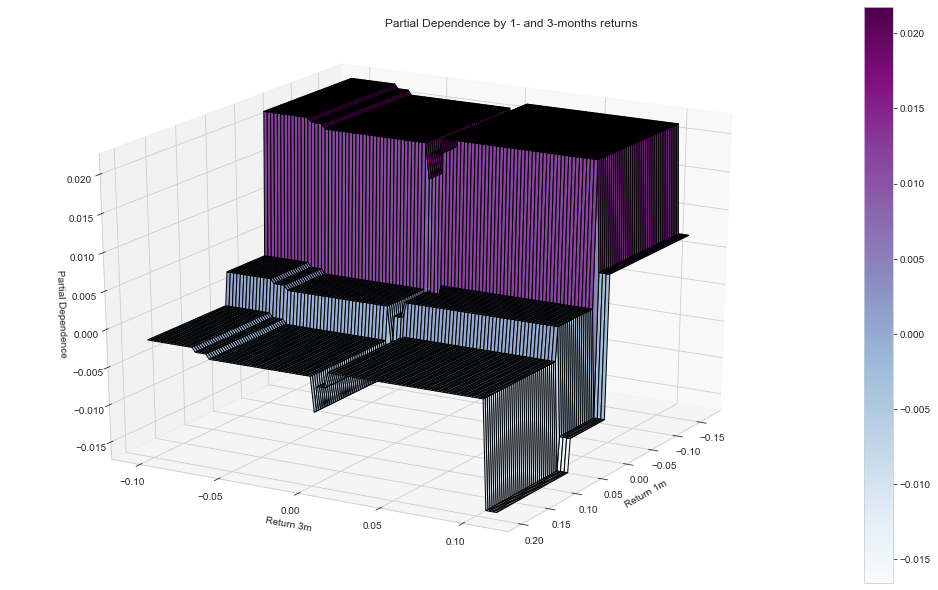

In [121]:
targets = ['return_1m', 'return_3m']
target_feature = [X_dummies_clean.columns.get_loc(t) for t in targets]
pdp, axes = partial_dependence(estimator=gb_clf,
                               features=target_feature,
                               X=X_dummies_clean,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z,
                       rstride=1,
                       cstride=1,
                       cmap=plt.cm.BuPu,
                       edgecolor='k')
ax.set_xlabel(' '.join(targets[0].split('_')).capitalize())
ax.set_ylabel(' '.join(targets[1].split('_')).capitalize())
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)

fig.colorbar(surf)
fig.suptitle('Partial Dependence by 1- and 3-months returns')
fig.tight_layout()

## XGBoost

See XGBoost [docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html) for details on parameters and usage.

### Configure

In [122]:
xgb_clf = XGBClassifier(max_depth=3,                  # Maximum tree depth for base learners.
                        learning_rate=0.1,            # Boosting learning rate (xgb's "eta")
                        n_estimators=100,             # Number of boosted trees to fit.
                        silent=True,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
#                         tree_method='gpu_hist',
                        n_jobs=-1,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### Cross-validate

In [123]:
algo = 'xgboost'

In [124]:
fname = f'results/{algo}_cv_result.joblib'
if not Path(fname).exists():
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  5.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.1min finished


### Plot Results

In [125]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.526489,0.686544
Accuracy,0.502422,0.617741
F1,0.390695,0.621109
Log Loss,-0.704178,-0.642888
Precision,0.567957,0.641114
Recall,0.500299,0.637672


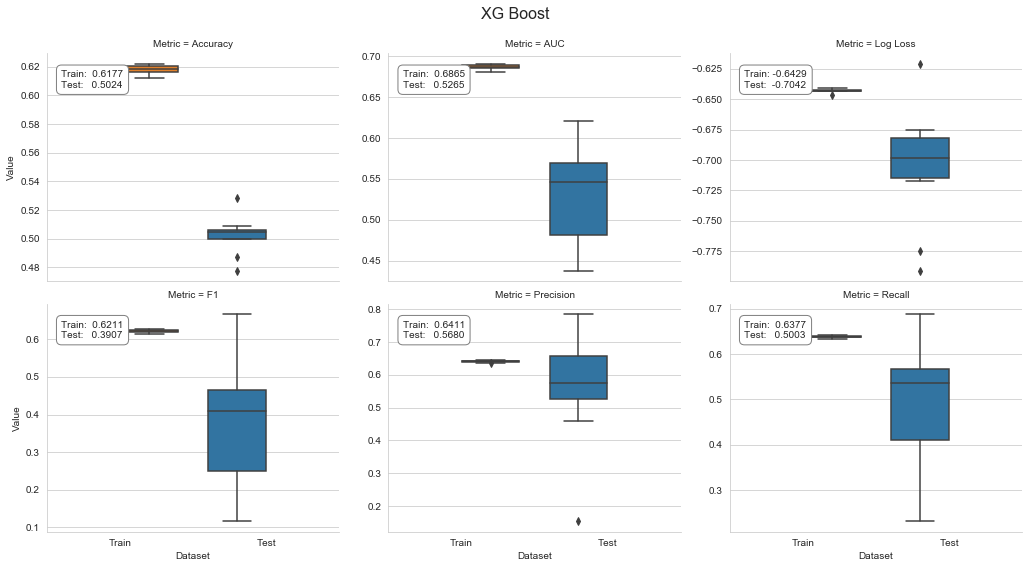

In [126]:
plot_result(xbg_result, model='XG Boost', fname=f'figures/{algo}_cv_result')

In [127]:
xgb_clf.fit(X=X_dummies, y=y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

In [128]:
fi = pd.Series(xgb_clf.feature_importances_, index=X_dummies.columns)

In [129]:
fi[fi>0].sort_values(ascending=False)

year_2008           0.051651
month_9             0.047281
month_7             0.041101
year_2007           0.040596
year_2012           0.040567
                      ...   
year_2001           0.002529
Energy              0.002415
momentum_3_12       0.001909
HML                 0.001070
Basic Industries    0.000949
Length: 61, dtype: float32

## LightGBM

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/Parameters.html) for details on parameters and usage.

### Configure

In [130]:
lgb_clf = LGBMClassifier(boosting_type='gbdt',
#                          device='gpu',
                         objective='binary',          # learning task
                         metric='auc',
                         num_leaves=31,               # Maximum tree leaves for base learners.
                         max_depth=-1,                # Maximum tree depth for base learners, -1 means no limit.
                         learning_rate=0.1,          # Adaptive lr via callback override in .fit() method  
                         n_estimators=100,            # Number of boosted trees to fit
                         subsample_for_bin=200000,    # Number of samples for constructing bins.
                         class_weight=None,           # dict, 'balanced' or None
                         min_split_gain=0.0,          # Minimum loss reduction for further split
                         min_child_weight=0.001,      # Minimum sum of instance weight(hessian)
                         min_child_samples=20,        # Minimum number of data need in a child(leaf)
                         subsample=1.0,               # Subsample ratio of training samples
                         subsample_freq=0,            # Frequency of subsampling, <=0: disabled
                         colsample_bytree=1.0,        # Subsampling ratio of features
                         reg_alpha=0.0,               # L1 regularization term on weights
                         reg_lambda=0.0,              # L2 regularization term on weights
                         random_state=42,             # Random number seed; default: C++ seed
                         n_jobs=-1,                   # Number of parallel threads.
                         silent=False,
                         importance_type='gain',      # default: 'split' or 'gain'
                        )

### Cross-Validate

#### Using categorical features

In [131]:
algo = 'lgb_factors'

In [132]:
fname = f'results/{algo}_cv_result.joblib'
if not Path(fname).exists():
    lgb_factor_cv_result, run_time[algo] = run_cv(lgb_clf, X=X_factors, fit_params={'categorical_feature': cat_cols})
    joblib.dump(lgb_factor_cv_result, fname)
else:
    lgb_factor_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   38.5s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   39.5s finished


##### Plot Results

In [133]:
lgb_factor_result = stack_results(lgb_factor_cv_result)
lgb_factor_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.536973,0.752844
Accuracy,0.516648,0.678934
F1,0.392878,0.685656
Log Loss,-0.724204,-0.590228
Precision,0.561619,0.693789
Recall,0.491467,0.692064


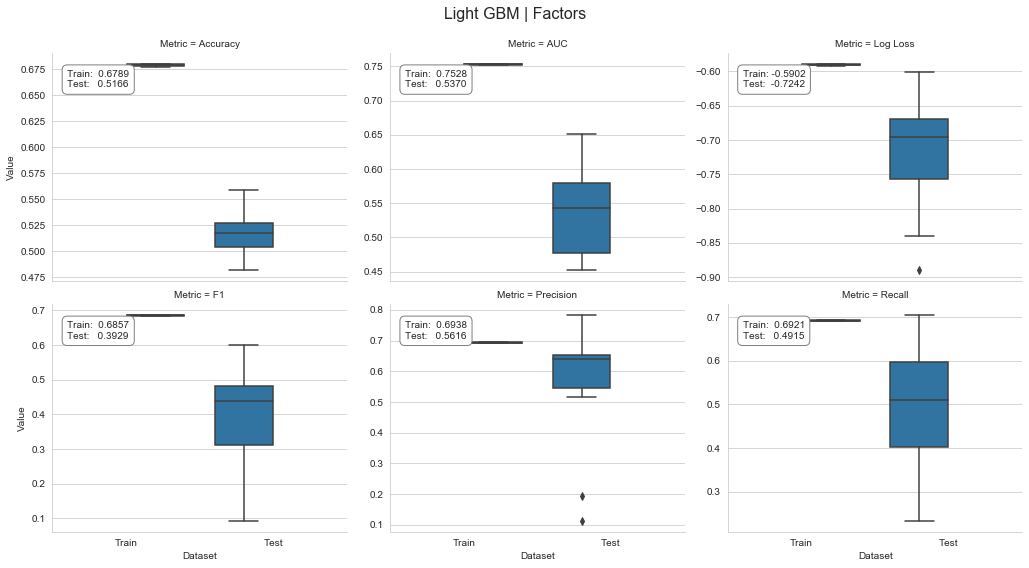

In [134]:
plot_result(lgb_factor_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

#### Using dummy variables

In [135]:
algo = 'lgb_dummies'

In [136]:
fname = f'results/{algo}_cv_result.joblib'
if not Path(fname).exists():
    lgb_dummy_cv_result, run_time[algo] = run_cv(lgb_clf)
    joblib.dump(lgb_dummy_cv_result, fname)
else:
    lgb_dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   31.8s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   32.5s finished


##### Plot results

In [137]:
lgb_dummy_result = stack_results(lgb_dummy_cv_result)
lgb_dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.525707,0.745327
Accuracy,0.511645,0.671121
F1,0.429873,0.677576
Log Loss,-0.705478,-0.599265
Precision,0.569996,0.690820
Recall,0.504142,0.686642


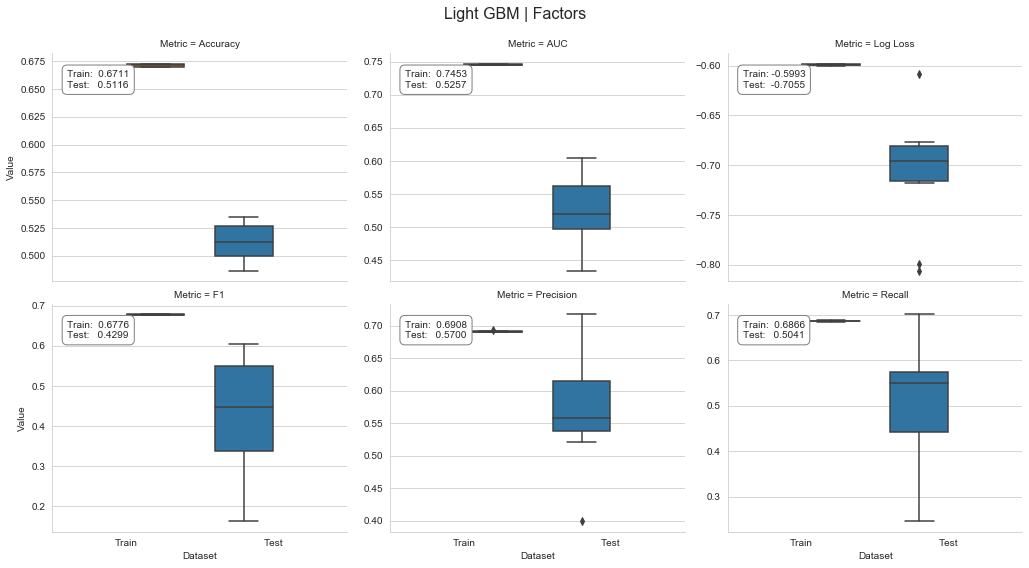

In [138]:
plot_result(lgb_dummy_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

## Catboost

See CatBoost [docs](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) for details on parameters and usage.

### CPU

#### Configure

In [139]:
cat_clf = CatBoostClassifier()

#### Cross-Validate

In [140]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

In [144]:
algo = 'catboost'

In [142]:
fname = f'results/{algo}_cv_result.joblib'
if not Path(fname).exists():
    cat_cv_result, run_time[algo] = run_cv(cat_clf, X=X_factors, fit_params={'cat_features': cat_cols_idx})
    joblib.dump(cat_cv_result, fname)
else:
    cat_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 32.5min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 32.5min finished


#### Plot Results

In [146]:
cat_result = stack_results(cat_cv_result)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.532007,0.804910
Accuracy,0.520849,0.723211
F1,0.486647,0.729410
Log Loss,-0.709081,-0.536393
Precision,0.578961,0.732615
Recall,0.514970,0.732244


In [ ]:
plot_result(cat_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

### GPU

#### Configure

In [149]:
cat_clf_gpu = CatBoostClassifier(task_type='GPU')

#### Cross-Validate

In [140]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

In [150]:
algo = 'catboost_gpu'

In [153]:
fname = f'results/{algo}_cv_result.joblib'
if not Path(fname).exists():
    cat_gpu_cv_result, run_time[algo] = run_cv(cat_clf_gpu, X=X_factors, 
                                               fit_params={'cat_features': cat_cols_idx})
    joblib.dump(cat_gpu_cv_result, fname)
else:
    cat_gpu_cv_result = joblib.load(fname)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.024524
0:	learn: 0.6883429	total: 24ms	remaining: 24s
1:	learn: 0.6838065	total: 51.1ms	remaining: 25.5s
2:	learn: 0.6795124	total: 74.9ms	remaining: 24.9s
3:	learn: 0.6753785	total: 102ms	remaining: 25.5s
4:	learn: 0.6714497	total: 129ms	remaining: 25.6s
5:	learn: 0.6677136	total: 153ms	remaining: 25.4s
6:	learn: 0.6642072	total: 174ms	remaining: 24.7s
7:	learn: 0.6607687	total: 197ms	remaining: 24.4s
8:	learn: 0.6575736	total: 220ms	remaining: 24.2s
9:	learn: 0.6545333	total: 246ms	remaining: 24.4s
10:	learn: 0.6515942	total: 267ms	remaining: 24s
11:	learn: 0.6488020	total: 289ms	remaining: 23.8s
12:	learn: 0.6461887	total: 312ms	remaining: 23.7s
13:	learn: 0.6437290	total: 336ms	remaining: 23.7s
14:	learn: 0.6413244	total: 359ms	remaining: 23.5s
15:	learn: 0.6390967	total: 381ms	remaining: 23.4s
16:	learn: 0.6369072	total: 402ms	remaining: 23.2s
17:	learn: 0.6348142	total: 422ms	remaining: 23s
18:	learn: 0.6328514	total: 443ms	remaining: 22.9s
19:	learn: 0.630

169:	learn: 0.5875837	total: 3.83s	remaining: 18.7s
170:	learn: 0.5875306	total: 3.85s	remaining: 18.6s
171:	learn: 0.5875135	total: 3.87s	remaining: 18.6s
172:	learn: 0.5874769	total: 3.89s	remaining: 18.6s
173:	learn: 0.5873989	total: 3.91s	remaining: 18.6s
174:	learn: 0.5873737	total: 3.93s	remaining: 18.5s
175:	learn: 0.5873517	total: 3.95s	remaining: 18.5s
176:	learn: 0.5873387	total: 3.97s	remaining: 18.5s
177:	learn: 0.5873027	total: 4s	remaining: 18.5s
178:	learn: 0.5872639	total: 4.02s	remaining: 18.4s
179:	learn: 0.5872491	total: 4.04s	remaining: 18.4s
180:	learn: 0.5872296	total: 4.07s	remaining: 18.4s
181:	learn: 0.5871773	total: 4.09s	remaining: 18.4s
182:	learn: 0.5871403	total: 4.12s	remaining: 18.4s
183:	learn: 0.5871164	total: 4.15s	remaining: 18.4s
184:	learn: 0.5870718	total: 4.17s	remaining: 18.4s
185:	learn: 0.5870378	total: 4.19s	remaining: 18.3s
186:	learn: 0.5870042	total: 4.21s	remaining: 18.3s
187:	learn: 0.5869937	total: 4.24s	remaining: 18.3s
188:	learn: 0.5

329:	learn: 0.5842239	total: 7.42s	remaining: 15.1s
330:	learn: 0.5842140	total: 7.44s	remaining: 15s
331:	learn: 0.5842083	total: 7.46s	remaining: 15s
332:	learn: 0.5841984	total: 7.48s	remaining: 15s
333:	learn: 0.5841909	total: 7.5s	remaining: 14.9s
334:	learn: 0.5841729	total: 7.52s	remaining: 14.9s
335:	learn: 0.5841523	total: 7.54s	remaining: 14.9s
336:	learn: 0.5841372	total: 7.56s	remaining: 14.9s
337:	learn: 0.5841081	total: 7.58s	remaining: 14.9s
338:	learn: 0.5841000	total: 7.61s	remaining: 14.8s
339:	learn: 0.5840823	total: 7.63s	remaining: 14.8s
340:	learn: 0.5840698	total: 7.65s	remaining: 14.8s
341:	learn: 0.5840439	total: 7.67s	remaining: 14.8s
342:	learn: 0.5840295	total: 7.7s	remaining: 14.7s
343:	learn: 0.5840135	total: 7.72s	remaining: 14.7s
344:	learn: 0.5840088	total: 7.74s	remaining: 14.7s
345:	learn: 0.5840053	total: 7.76s	remaining: 14.7s
346:	learn: 0.5839947	total: 7.78s	remaining: 14.6s
347:	learn: 0.5839838	total: 7.8s	remaining: 14.6s
348:	learn: 0.5839653

497:	learn: 0.5820929	total: 11s	remaining: 11.1s
498:	learn: 0.5820777	total: 11s	remaining: 11.1s
499:	learn: 0.5820668	total: 11.1s	remaining: 11.1s
500:	learn: 0.5820600	total: 11.1s	remaining: 11s
501:	learn: 0.5820494	total: 11.1s	remaining: 11s
502:	learn: 0.5820368	total: 11.1s	remaining: 11s
503:	learn: 0.5820254	total: 11.2s	remaining: 11s
504:	learn: 0.5820202	total: 11.2s	remaining: 11s
505:	learn: 0.5820031	total: 11.2s	remaining: 10.9s
506:	learn: 0.5819676	total: 11.2s	remaining: 10.9s
507:	learn: 0.5819531	total: 11.2s	remaining: 10.9s
508:	learn: 0.5819301	total: 11.3s	remaining: 10.9s
509:	learn: 0.5819258	total: 11.3s	remaining: 10.8s
510:	learn: 0.5819179	total: 11.3s	remaining: 10.8s
511:	learn: 0.5818936	total: 11.3s	remaining: 10.8s
512:	learn: 0.5818838	total: 11.3s	remaining: 10.8s
513:	learn: 0.5818732	total: 11.4s	remaining: 10.7s
514:	learn: 0.5818602	total: 11.4s	remaining: 10.7s
515:	learn: 0.5818414	total: 11.4s	remaining: 10.7s
516:	learn: 0.5818078	tota

661:	learn: 0.5800471	total: 14.6s	remaining: 7.46s
662:	learn: 0.5800352	total: 14.6s	remaining: 7.44s
663:	learn: 0.5800265	total: 14.7s	remaining: 7.41s
664:	learn: 0.5800192	total: 14.7s	remaining: 7.39s
665:	learn: 0.5800134	total: 14.7s	remaining: 7.37s
666:	learn: 0.5800071	total: 14.7s	remaining: 7.35s
667:	learn: 0.5800013	total: 14.8s	remaining: 7.33s
668:	learn: 0.5799891	total: 14.8s	remaining: 7.31s
669:	learn: 0.5799838	total: 14.8s	remaining: 7.29s
670:	learn: 0.5799758	total: 14.8s	remaining: 7.26s
671:	learn: 0.5799632	total: 14.8s	remaining: 7.24s
672:	learn: 0.5799553	total: 14.9s	remaining: 7.22s
673:	learn: 0.5799470	total: 14.9s	remaining: 7.2s
674:	learn: 0.5799299	total: 14.9s	remaining: 7.18s
675:	learn: 0.5799176	total: 14.9s	remaining: 7.15s
676:	learn: 0.5799097	total: 14.9s	remaining: 7.13s
677:	learn: 0.5799034	total: 15s	remaining: 7.11s
678:	learn: 0.5798948	total: 15s	remaining: 7.09s
679:	learn: 0.5798833	total: 15s	remaining: 7.07s
680:	learn: 0.57987

824:	learn: 0.5784592	total: 18.2s	remaining: 3.86s
825:	learn: 0.5784527	total: 18.2s	remaining: 3.84s
826:	learn: 0.5784447	total: 18.3s	remaining: 3.82s
827:	learn: 0.5784331	total: 18.3s	remaining: 3.8s
828:	learn: 0.5784101	total: 18.3s	remaining: 3.77s
829:	learn: 0.5784025	total: 18.3s	remaining: 3.75s
830:	learn: 0.5783945	total: 18.3s	remaining: 3.73s
831:	learn: 0.5783859	total: 18.4s	remaining: 3.71s
832:	learn: 0.5783780	total: 18.4s	remaining: 3.69s
833:	learn: 0.5783712	total: 18.4s	remaining: 3.66s
834:	learn: 0.5783612	total: 18.4s	remaining: 3.64s
835:	learn: 0.5783551	total: 18.5s	remaining: 3.62s
836:	learn: 0.5783452	total: 18.5s	remaining: 3.6s
837:	learn: 0.5783399	total: 18.5s	remaining: 3.58s
838:	learn: 0.5783319	total: 18.5s	remaining: 3.55s
839:	learn: 0.5783221	total: 18.5s	remaining: 3.53s
840:	learn: 0.5783133	total: 18.6s	remaining: 3.51s
841:	learn: 0.5783080	total: 18.6s	remaining: 3.49s
842:	learn: 0.5783025	total: 18.6s	remaining: 3.46s
843:	learn: 0.

988:	learn: 0.5769675	total: 21.8s	remaining: 242ms
989:	learn: 0.5769581	total: 21.8s	remaining: 220ms
990:	learn: 0.5769515	total: 21.8s	remaining: 198ms
991:	learn: 0.5769480	total: 21.9s	remaining: 176ms
992:	learn: 0.5769401	total: 21.9s	remaining: 154ms
993:	learn: 0.5769328	total: 21.9s	remaining: 132ms
994:	learn: 0.5769244	total: 21.9s	remaining: 110ms
995:	learn: 0.5769159	total: 21.9s	remaining: 88.2ms
996:	learn: 0.5769075	total: 22s	remaining: 66.1ms
997:	learn: 0.5769023	total: 22s	remaining: 44.1ms
998:	learn: 0.5768921	total: 22s	remaining: 22ms
999:	learn: 0.5768777	total: 22s	remaining: 0us
Learning rate set to 0.024531
0:	learn: 0.6884094	total: 20.1ms	remaining: 20.1s
1:	learn: 0.6838612	total: 39.6ms	remaining: 19.7s
2:	learn: 0.6794731	total: 60.7ms	remaining: 20.2s
3:	learn: 0.6753598	total: 81.6ms	remaining: 20.3s
4:	learn: 0.6714972	total: 104ms	remaining: 20.7s
5:	learn: 0.6677770	total: 124ms	remaining: 20.5s
6:	learn: 0.6643543	total: 144ms	remaining: 20.4s


156:	learn: 0.5878385	total: 3.39s	remaining: 18.2s
157:	learn: 0.5878139	total: 3.42s	remaining: 18.2s
158:	learn: 0.5877690	total: 3.44s	remaining: 18.2s
159:	learn: 0.5877304	total: 3.46s	remaining: 18.2s
160:	learn: 0.5877023	total: 3.48s	remaining: 18.1s
161:	learn: 0.5876860	total: 3.5s	remaining: 18.1s
162:	learn: 0.5876652	total: 3.52s	remaining: 18.1s
163:	learn: 0.5876316	total: 3.54s	remaining: 18.1s
164:	learn: 0.5876034	total: 3.57s	remaining: 18.1s
165:	learn: 0.5875846	total: 3.59s	remaining: 18.1s
166:	learn: 0.5875532	total: 3.62s	remaining: 18s
167:	learn: 0.5875193	total: 3.64s	remaining: 18s
168:	learn: 0.5875056	total: 3.66s	remaining: 18s
169:	learn: 0.5874860	total: 3.68s	remaining: 18s
170:	learn: 0.5874595	total: 3.7s	remaining: 18s
171:	learn: 0.5874483	total: 3.72s	remaining: 17.9s
172:	learn: 0.5874067	total: 3.74s	remaining: 17.9s
173:	learn: 0.5873921	total: 3.77s	remaining: 17.9s
174:	learn: 0.5873353	total: 3.79s	remaining: 17.8s
175:	learn: 0.5873055	to

319:	learn: 0.5843265	total: 6.94s	remaining: 14.7s
320:	learn: 0.5843060	total: 6.96s	remaining: 14.7s
321:	learn: 0.5842974	total: 6.98s	remaining: 14.7s
322:	learn: 0.5842683	total: 7s	remaining: 14.7s
323:	learn: 0.5842582	total: 7.03s	remaining: 14.7s
324:	learn: 0.5842449	total: 7.05s	remaining: 14.7s
325:	learn: 0.5842050	total: 7.08s	remaining: 14.6s
326:	learn: 0.5842000	total: 7.1s	remaining: 14.6s
327:	learn: 0.5841875	total: 7.12s	remaining: 14.6s
328:	learn: 0.5841778	total: 7.14s	remaining: 14.6s
329:	learn: 0.5841583	total: 7.17s	remaining: 14.6s
330:	learn: 0.5841334	total: 7.2s	remaining: 14.5s
331:	learn: 0.5841282	total: 7.22s	remaining: 14.5s
332:	learn: 0.5841141	total: 7.24s	remaining: 14.5s
333:	learn: 0.5841002	total: 7.26s	remaining: 14.5s
334:	learn: 0.5840794	total: 7.28s	remaining: 14.5s
335:	learn: 0.5840680	total: 7.3s	remaining: 14.4s
336:	learn: 0.5840605	total: 7.33s	remaining: 14.4s
337:	learn: 0.5840547	total: 7.35s	remaining: 14.4s
338:	learn: 0.5840

487:	learn: 0.5822090	total: 10.5s	remaining: 11s
488:	learn: 0.5821848	total: 10.6s	remaining: 11s
489:	learn: 0.5821747	total: 10.6s	remaining: 11s
490:	learn: 0.5821562	total: 10.6s	remaining: 11s
491:	learn: 0.5821443	total: 10.6s	remaining: 11s
492:	learn: 0.5821401	total: 10.6s	remaining: 10.9s
493:	learn: 0.5821331	total: 10.7s	remaining: 10.9s
494:	learn: 0.5821218	total: 10.7s	remaining: 10.9s
495:	learn: 0.5821161	total: 10.7s	remaining: 10.9s
496:	learn: 0.5821059	total: 10.7s	remaining: 10.9s
497:	learn: 0.5820959	total: 10.8s	remaining: 10.8s
498:	learn: 0.5820814	total: 10.8s	remaining: 10.8s
499:	learn: 0.5820717	total: 10.8s	remaining: 10.8s
500:	learn: 0.5820577	total: 10.8s	remaining: 10.8s
501:	learn: 0.5820413	total: 10.8s	remaining: 10.8s
502:	learn: 0.5820325	total: 10.9s	remaining: 10.7s
503:	learn: 0.5820195	total: 10.9s	remaining: 10.7s
504:	learn: 0.5820128	total: 10.9s	remaining: 10.7s
505:	learn: 0.5820090	total: 10.9s	remaining: 10.7s
506:	learn: 0.5819818	

655:	learn: 0.5802280	total: 14.1s	remaining: 7.41s
656:	learn: 0.5802157	total: 14.2s	remaining: 7.39s
657:	learn: 0.5802073	total: 14.2s	remaining: 7.37s
658:	learn: 0.5801985	total: 14.2s	remaining: 7.35s
659:	learn: 0.5801905	total: 14.2s	remaining: 7.33s
660:	learn: 0.5801832	total: 14.2s	remaining: 7.31s
661:	learn: 0.5801748	total: 14.3s	remaining: 7.29s
662:	learn: 0.5801709	total: 14.3s	remaining: 7.26s
663:	learn: 0.5801644	total: 14.3s	remaining: 7.24s
664:	learn: 0.5801592	total: 14.3s	remaining: 7.22s
665:	learn: 0.5801496	total: 14.4s	remaining: 7.2s
666:	learn: 0.5801358	total: 14.4s	remaining: 7.18s
667:	learn: 0.5801220	total: 14.4s	remaining: 7.16s
668:	learn: 0.5801150	total: 14.4s	remaining: 7.14s
669:	learn: 0.5801041	total: 14.4s	remaining: 7.11s
670:	learn: 0.5800964	total: 14.5s	remaining: 7.09s
671:	learn: 0.5800859	total: 14.5s	remaining: 7.07s
672:	learn: 0.5800712	total: 14.5s	remaining: 7.05s
673:	learn: 0.5800603	total: 14.5s	remaining: 7.03s
674:	learn: 0

821:	learn: 0.5785023	total: 17.7s	remaining: 3.84s
822:	learn: 0.5784933	total: 17.8s	remaining: 3.82s
823:	learn: 0.5784880	total: 17.8s	remaining: 3.8s
824:	learn: 0.5784768	total: 17.8s	remaining: 3.78s
825:	learn: 0.5784587	total: 17.8s	remaining: 3.76s
826:	learn: 0.5784520	total: 17.9s	remaining: 3.73s
827:	learn: 0.5784375	total: 17.9s	remaining: 3.71s
828:	learn: 0.5784284	total: 17.9s	remaining: 3.69s
829:	learn: 0.5784228	total: 17.9s	remaining: 3.67s
830:	learn: 0.5784122	total: 17.9s	remaining: 3.65s
831:	learn: 0.5784049	total: 18s	remaining: 3.63s
832:	learn: 0.5783986	total: 18s	remaining: 3.61s
833:	learn: 0.5783898	total: 18s	remaining: 3.58s
834:	learn: 0.5783780	total: 18s	remaining: 3.56s
835:	learn: 0.5783692	total: 18.1s	remaining: 3.54s
836:	learn: 0.5783576	total: 18.1s	remaining: 3.52s
837:	learn: 0.5783468	total: 18.1s	remaining: 3.5s
838:	learn: 0.5783315	total: 18.1s	remaining: 3.48s
839:	learn: 0.5783176	total: 18.1s	remaining: 3.45s
840:	learn: 0.5783044	

989:	learn: 0.5769811	total: 21.4s	remaining: 216ms
990:	learn: 0.5769741	total: 21.4s	remaining: 194ms
991:	learn: 0.5769704	total: 21.4s	remaining: 173ms
992:	learn: 0.5769649	total: 21.5s	remaining: 151ms
993:	learn: 0.5769512	total: 21.5s	remaining: 130ms
994:	learn: 0.5769463	total: 21.5s	remaining: 108ms
995:	learn: 0.5769397	total: 21.5s	remaining: 86.5ms
996:	learn: 0.5769318	total: 21.6s	remaining: 64.9ms
997:	learn: 0.5769214	total: 21.6s	remaining: 43.3ms
998:	learn: 0.5769121	total: 21.6s	remaining: 21.6ms
999:	learn: 0.5769027	total: 21.6s	remaining: 0us
Learning rate set to 0.024538
0:	learn: 0.6883928	total: 25ms	remaining: 25s
1:	learn: 0.6839043	total: 48.3ms	remaining: 24.1s
2:	learn: 0.6795184	total: 70.1ms	remaining: 23.3s
3:	learn: 0.6753699	total: 92.1ms	remaining: 22.9s
4:	learn: 0.6714313	total: 117ms	remaining: 23.3s
5:	learn: 0.6677126	total: 141ms	remaining: 23.4s
6:	learn: 0.6642191	total: 162ms	remaining: 22.9s
7:	learn: 0.6608046	total: 187ms	remaining: 23

156:	learn: 0.5877803	total: 3.45s	remaining: 18.5s
157:	learn: 0.5877617	total: 3.47s	remaining: 18.5s
158:	learn: 0.5877283	total: 3.49s	remaining: 18.5s
159:	learn: 0.5876855	total: 3.52s	remaining: 18.5s
160:	learn: 0.5876604	total: 3.54s	remaining: 18.4s
161:	learn: 0.5876162	total: 3.56s	remaining: 18.4s
162:	learn: 0.5875825	total: 3.59s	remaining: 18.4s
163:	learn: 0.5875500	total: 3.61s	remaining: 18.4s
164:	learn: 0.5875211	total: 3.63s	remaining: 18.4s
165:	learn: 0.5874760	total: 3.66s	remaining: 18.4s
166:	learn: 0.5874354	total: 3.68s	remaining: 18.4s
167:	learn: 0.5874083	total: 3.7s	remaining: 18.3s
168:	learn: 0.5873847	total: 3.73s	remaining: 18.3s
169:	learn: 0.5873669	total: 3.75s	remaining: 18.3s
170:	learn: 0.5873372	total: 3.77s	remaining: 18.3s
171:	learn: 0.5873189	total: 3.8s	remaining: 18.3s
172:	learn: 0.5873078	total: 3.82s	remaining: 18.3s
173:	learn: 0.5872897	total: 3.85s	remaining: 18.3s
174:	learn: 0.5872563	total: 3.87s	remaining: 18.2s
175:	learn: 0.

319:	learn: 0.5842411	total: 7.04s	remaining: 15s
320:	learn: 0.5842327	total: 7.07s	remaining: 15s
321:	learn: 0.5842285	total: 7.09s	remaining: 14.9s
322:	learn: 0.5842020	total: 7.11s	remaining: 14.9s
323:	learn: 0.5841793	total: 7.13s	remaining: 14.9s
324:	learn: 0.5841507	total: 7.15s	remaining: 14.9s
325:	learn: 0.5841026	total: 7.17s	remaining: 14.8s
326:	learn: 0.5840897	total: 7.2s	remaining: 14.8s
327:	learn: 0.5840789	total: 7.22s	remaining: 14.8s
328:	learn: 0.5840734	total: 7.24s	remaining: 14.8s
329:	learn: 0.5840347	total: 7.26s	remaining: 14.7s
330:	learn: 0.5840146	total: 7.28s	remaining: 14.7s
331:	learn: 0.5839916	total: 7.3s	remaining: 14.7s
332:	learn: 0.5839820	total: 7.33s	remaining: 14.7s
333:	learn: 0.5839584	total: 7.34s	remaining: 14.6s
334:	learn: 0.5839534	total: 7.37s	remaining: 14.6s
335:	learn: 0.5839344	total: 7.39s	remaining: 14.6s
336:	learn: 0.5839279	total: 7.41s	remaining: 14.6s
337:	learn: 0.5839124	total: 7.44s	remaining: 14.6s
338:	learn: 0.5838

482:	learn: 0.5820495	total: 10.7s	remaining: 11.4s
483:	learn: 0.5820256	total: 10.7s	remaining: 11.4s
484:	learn: 0.5820224	total: 10.7s	remaining: 11.4s
485:	learn: 0.5819995	total: 10.7s	remaining: 11.3s
486:	learn: 0.5819883	total: 10.7s	remaining: 11.3s
487:	learn: 0.5819754	total: 10.8s	remaining: 11.3s
488:	learn: 0.5819557	total: 10.8s	remaining: 11.3s
489:	learn: 0.5819489	total: 10.8s	remaining: 11.3s
490:	learn: 0.5819413	total: 10.8s	remaining: 11.2s
491:	learn: 0.5819332	total: 10.9s	remaining: 11.2s
492:	learn: 0.5819247	total: 10.9s	remaining: 11.2s
493:	learn: 0.5819001	total: 10.9s	remaining: 11.2s
494:	learn: 0.5818906	total: 10.9s	remaining: 11.1s
495:	learn: 0.5818830	total: 10.9s	remaining: 11.1s
496:	learn: 0.5818766	total: 11s	remaining: 11.1s
497:	learn: 0.5818687	total: 11s	remaining: 11.1s
498:	learn: 0.5818630	total: 11s	remaining: 11s
499:	learn: 0.5818492	total: 11s	remaining: 11s
500:	learn: 0.5818445	total: 11s	remaining: 11s
501:	learn: 0.5818325	total:

647:	learn: 0.5800906	total: 14.3s	remaining: 7.75s
648:	learn: 0.5800832	total: 14.3s	remaining: 7.73s
649:	learn: 0.5800793	total: 14.3s	remaining: 7.71s
650:	learn: 0.5800737	total: 14.3s	remaining: 7.69s
651:	learn: 0.5800634	total: 14.4s	remaining: 7.67s
652:	learn: 0.5800579	total: 14.4s	remaining: 7.65s
653:	learn: 0.5800427	total: 14.4s	remaining: 7.62s
654:	learn: 0.5800336	total: 14.4s	remaining: 7.6s
655:	learn: 0.5800263	total: 14.5s	remaining: 7.58s
656:	learn: 0.5800184	total: 14.5s	remaining: 7.56s
657:	learn: 0.5800021	total: 14.5s	remaining: 7.53s
658:	learn: 0.5799912	total: 14.5s	remaining: 7.51s
659:	learn: 0.5799851	total: 14.5s	remaining: 7.49s
660:	learn: 0.5799716	total: 14.6s	remaining: 7.47s
661:	learn: 0.5799606	total: 14.6s	remaining: 7.45s
662:	learn: 0.5799454	total: 14.6s	remaining: 7.42s
663:	learn: 0.5799352	total: 14.6s	remaining: 7.4s
664:	learn: 0.5799250	total: 14.6s	remaining: 7.38s
665:	learn: 0.5799146	total: 14.7s	remaining: 7.36s
666:	learn: 0.

815:	learn: 0.5784169	total: 18s	remaining: 4.07s
816:	learn: 0.5784044	total: 18.1s	remaining: 4.05s
817:	learn: 0.5783898	total: 18.1s	remaining: 4.02s
818:	learn: 0.5783723	total: 18.1s	remaining: 4s
819:	learn: 0.5783549	total: 18.1s	remaining: 3.98s
820:	learn: 0.5783483	total: 18.1s	remaining: 3.96s
821:	learn: 0.5783432	total: 18.2s	remaining: 3.94s
822:	learn: 0.5783374	total: 18.2s	remaining: 3.91s
823:	learn: 0.5783262	total: 18.2s	remaining: 3.89s
824:	learn: 0.5783173	total: 18.2s	remaining: 3.87s
825:	learn: 0.5783066	total: 18.3s	remaining: 3.85s
826:	learn: 0.5782947	total: 18.3s	remaining: 3.83s
827:	learn: 0.5782847	total: 18.3s	remaining: 3.8s
828:	learn: 0.5782784	total: 18.3s	remaining: 3.78s
829:	learn: 0.5782623	total: 18.4s	remaining: 3.76s
830:	learn: 0.5782476	total: 18.4s	remaining: 3.74s
831:	learn: 0.5782391	total: 18.4s	remaining: 3.72s
832:	learn: 0.5782287	total: 18.4s	remaining: 3.7s
833:	learn: 0.5782218	total: 18.5s	remaining: 3.67s
834:	learn: 0.57821

979:	learn: 0.5769242	total: 21.8s	remaining: 445ms
980:	learn: 0.5769185	total: 21.8s	remaining: 423ms
981:	learn: 0.5769120	total: 21.9s	remaining: 401ms
982:	learn: 0.5769043	total: 21.9s	remaining: 379ms
983:	learn: 0.5768892	total: 21.9s	remaining: 356ms
984:	learn: 0.5768802	total: 21.9s	remaining: 334ms
985:	learn: 0.5768720	total: 22s	remaining: 312ms
986:	learn: 0.5768634	total: 22s	remaining: 290ms
987:	learn: 0.5768562	total: 22s	remaining: 267ms
988:	learn: 0.5768420	total: 22s	remaining: 245ms
989:	learn: 0.5768336	total: 22s	remaining: 223ms
990:	learn: 0.5768293	total: 22.1s	remaining: 200ms
991:	learn: 0.5768234	total: 22.1s	remaining: 178ms
992:	learn: 0.5768169	total: 22.1s	remaining: 156ms
993:	learn: 0.5768087	total: 22.1s	remaining: 134ms
994:	learn: 0.5768026	total: 22.2s	remaining: 111ms
995:	learn: 0.5767953	total: 22.2s	remaining: 89.1ms
996:	learn: 0.5767834	total: 22.2s	remaining: 66.8ms
997:	learn: 0.5767723	total: 22.2s	remaining: 44.5ms
998:	learn: 0.57676

147:	learn: 0.5877618	total: 3.33s	remaining: 19.2s
148:	learn: 0.5877261	total: 3.36s	remaining: 19.2s
149:	learn: 0.5876901	total: 3.38s	remaining: 19.1s
150:	learn: 0.5876450	total: 3.4s	remaining: 19.1s
151:	learn: 0.5876182	total: 3.42s	remaining: 19.1s
152:	learn: 0.5875639	total: 3.44s	remaining: 19s
153:	learn: 0.5875119	total: 3.46s	remaining: 19s
154:	learn: 0.5874712	total: 3.49s	remaining: 19s
155:	learn: 0.5874492	total: 3.51s	remaining: 19s
156:	learn: 0.5874184	total: 3.53s	remaining: 19s
157:	learn: 0.5873839	total: 3.56s	remaining: 19s
158:	learn: 0.5873248	total: 3.58s	remaining: 18.9s
159:	learn: 0.5872772	total: 3.6s	remaining: 18.9s
160:	learn: 0.5872517	total: 3.63s	remaining: 18.9s
161:	learn: 0.5872221	total: 3.65s	remaining: 18.9s
162:	learn: 0.5872006	total: 3.67s	remaining: 18.9s
163:	learn: 0.5871836	total: 3.7s	remaining: 18.9s
164:	learn: 0.5871604	total: 3.72s	remaining: 18.8s
165:	learn: 0.5871377	total: 3.75s	remaining: 18.8s
166:	learn: 0.5871072	total

310:	learn: 0.5841361	total: 6.93s	remaining: 15.4s
311:	learn: 0.5841129	total: 6.96s	remaining: 15.3s
312:	learn: 0.5841009	total: 6.98s	remaining: 15.3s
313:	learn: 0.5840927	total: 7s	remaining: 15.3s
314:	learn: 0.5840682	total: 7.02s	remaining: 15.3s
315:	learn: 0.5840475	total: 7.04s	remaining: 15.2s
316:	learn: 0.5840423	total: 7.06s	remaining: 15.2s
317:	learn: 0.5840213	total: 7.09s	remaining: 15.2s
318:	learn: 0.5840067	total: 7.11s	remaining: 15.2s
319:	learn: 0.5839902	total: 7.13s	remaining: 15.2s
320:	learn: 0.5839739	total: 7.16s	remaining: 15.1s
321:	learn: 0.5839616	total: 7.18s	remaining: 15.1s
322:	learn: 0.5839531	total: 7.2s	remaining: 15.1s
323:	learn: 0.5839302	total: 7.22s	remaining: 15.1s
324:	learn: 0.5839143	total: 7.24s	remaining: 15s
325:	learn: 0.5839065	total: 7.26s	remaining: 15s
326:	learn: 0.5838891	total: 7.29s	remaining: 15s
327:	learn: 0.5838774	total: 7.31s	remaining: 15s
328:	learn: 0.5838673	total: 7.33s	remaining: 14.9s
329:	learn: 0.5838476	to

477:	learn: 0.5818743	total: 10.5s	remaining: 11.5s
478:	learn: 0.5818663	total: 10.5s	remaining: 11.5s
479:	learn: 0.5818310	total: 10.6s	remaining: 11.4s
480:	learn: 0.5818138	total: 10.6s	remaining: 11.4s
481:	learn: 0.5818038	total: 10.6s	remaining: 11.4s
482:	learn: 0.5817905	total: 10.6s	remaining: 11.4s
483:	learn: 0.5817748	total: 10.7s	remaining: 11.4s
484:	learn: 0.5817579	total: 10.7s	remaining: 11.3s
485:	learn: 0.5817514	total: 10.7s	remaining: 11.3s
486:	learn: 0.5817369	total: 10.7s	remaining: 11.3s
487:	learn: 0.5817156	total: 10.7s	remaining: 11.3s
488:	learn: 0.5817057	total: 10.8s	remaining: 11.2s
489:	learn: 0.5816912	total: 10.8s	remaining: 11.2s
490:	learn: 0.5816767	total: 10.8s	remaining: 11.2s
491:	learn: 0.5816674	total: 10.8s	remaining: 11.2s
492:	learn: 0.5816597	total: 10.8s	remaining: 11.2s
493:	learn: 0.5816551	total: 10.9s	remaining: 11.1s
494:	learn: 0.5816394	total: 10.9s	remaining: 11.1s
495:	learn: 0.5816318	total: 10.9s	remaining: 11.1s
496:	learn: 

645:	learn: 0.5799168	total: 14.2s	remaining: 7.76s
646:	learn: 0.5799063	total: 14.2s	remaining: 7.74s
647:	learn: 0.5798910	total: 14.2s	remaining: 7.72s
648:	learn: 0.5798839	total: 14.2s	remaining: 7.7s
649:	learn: 0.5798727	total: 14.3s	remaining: 7.68s
650:	learn: 0.5798655	total: 14.3s	remaining: 7.66s
651:	learn: 0.5798570	total: 14.3s	remaining: 7.63s
652:	learn: 0.5798438	total: 14.3s	remaining: 7.61s
653:	learn: 0.5798270	total: 14.3s	remaining: 7.59s
654:	learn: 0.5798124	total: 14.4s	remaining: 7.57s
655:	learn: 0.5798061	total: 14.4s	remaining: 7.54s
656:	learn: 0.5797954	total: 14.4s	remaining: 7.52s
657:	learn: 0.5797866	total: 14.4s	remaining: 7.5s
658:	learn: 0.5797639	total: 14.5s	remaining: 7.48s
659:	learn: 0.5797484	total: 14.5s	remaining: 7.46s
660:	learn: 0.5797362	total: 14.5s	remaining: 7.43s
661:	learn: 0.5797277	total: 14.5s	remaining: 7.41s
662:	learn: 0.5797181	total: 14.5s	remaining: 7.39s
663:	learn: 0.5797021	total: 14.6s	remaining: 7.37s
664:	learn: 0.

805:	learn: 0.5782305	total: 17.7s	remaining: 4.26s
806:	learn: 0.5782225	total: 17.7s	remaining: 4.24s
807:	learn: 0.5782145	total: 17.8s	remaining: 4.22s
808:	learn: 0.5782081	total: 17.8s	remaining: 4.2s
809:	learn: 0.5781990	total: 17.8s	remaining: 4.18s
810:	learn: 0.5781941	total: 17.8s	remaining: 4.16s
811:	learn: 0.5781870	total: 17.9s	remaining: 4.13s
812:	learn: 0.5781788	total: 17.9s	remaining: 4.11s
813:	learn: 0.5781659	total: 17.9s	remaining: 4.09s
814:	learn: 0.5781578	total: 17.9s	remaining: 4.07s
815:	learn: 0.5781457	total: 17.9s	remaining: 4.05s
816:	learn: 0.5781369	total: 18s	remaining: 4.02s
817:	learn: 0.5781289	total: 18s	remaining: 4s
818:	learn: 0.5781153	total: 18s	remaining: 3.98s
819:	learn: 0.5781027	total: 18s	remaining: 3.96s
820:	learn: 0.5780934	total: 18s	remaining: 3.93s
821:	learn: 0.5780892	total: 18.1s	remaining: 3.91s
822:	learn: 0.5780822	total: 18.1s	remaining: 3.89s
823:	learn: 0.5780741	total: 18.1s	remaining: 3.87s
824:	learn: 0.5780680	tota

967:	learn: 0.5767916	total: 21.3s	remaining: 704ms
968:	learn: 0.5767870	total: 21.3s	remaining: 682ms
969:	learn: 0.5767809	total: 21.3s	remaining: 660ms
970:	learn: 0.5767767	total: 21.4s	remaining: 638ms
971:	learn: 0.5767670	total: 21.4s	remaining: 616ms
972:	learn: 0.5767561	total: 21.4s	remaining: 594ms
973:	learn: 0.5767484	total: 21.4s	remaining: 572ms
974:	learn: 0.5767427	total: 21.4s	remaining: 550ms
975:	learn: 0.5767346	total: 21.5s	remaining: 528ms
976:	learn: 0.5767290	total: 21.5s	remaining: 506ms
977:	learn: 0.5767209	total: 21.5s	remaining: 484ms
978:	learn: 0.5767117	total: 21.5s	remaining: 462ms
979:	learn: 0.5767060	total: 21.6s	remaining: 440ms
980:	learn: 0.5767009	total: 21.6s	remaining: 418ms
981:	learn: 0.5766897	total: 21.6s	remaining: 396ms
982:	learn: 0.5766832	total: 21.6s	remaining: 374ms
983:	learn: 0.5766690	total: 21.6s	remaining: 352ms
984:	learn: 0.5766650	total: 21.7s	remaining: 330ms
985:	learn: 0.5766529	total: 21.7s	remaining: 308ms
986:	learn: 

132:	learn: 0.5886796	total: 2.98s	remaining: 19.4s
133:	learn: 0.5886350	total: 3s	remaining: 19.4s
134:	learn: 0.5885698	total: 3.03s	remaining: 19.4s
135:	learn: 0.5885209	total: 3.05s	remaining: 19.4s
136:	learn: 0.5884647	total: 3.08s	remaining: 19.4s
137:	learn: 0.5884436	total: 3.1s	remaining: 19.4s
138:	learn: 0.5884073	total: 3.12s	remaining: 19.4s
139:	learn: 0.5883594	total: 3.15s	remaining: 19.3s
140:	learn: 0.5883154	total: 3.17s	remaining: 19.3s
141:	learn: 0.5882979	total: 3.19s	remaining: 19.3s
142:	learn: 0.5882403	total: 3.22s	remaining: 19.3s
143:	learn: 0.5882058	total: 3.24s	remaining: 19.3s
144:	learn: 0.5881675	total: 3.26s	remaining: 19.2s
145:	learn: 0.5881516	total: 3.28s	remaining: 19.2s
146:	learn: 0.5881263	total: 3.31s	remaining: 19.2s
147:	learn: 0.5880891	total: 3.33s	remaining: 19.1s
148:	learn: 0.5880435	total: 3.35s	remaining: 19.1s
149:	learn: 0.5879954	total: 3.37s	remaining: 19.1s
150:	learn: 0.5879711	total: 3.39s	remaining: 19.1s
151:	learn: 0.58

293:	learn: 0.5846633	total: 6.83s	remaining: 16.4s
294:	learn: 0.5846496	total: 6.85s	remaining: 16.4s
295:	learn: 0.5846261	total: 6.88s	remaining: 16.4s
296:	learn: 0.5846115	total: 6.9s	remaining: 16.3s
297:	learn: 0.5846027	total: 6.92s	remaining: 16.3s
298:	learn: 0.5845858	total: 6.95s	remaining: 16.3s
299:	learn: 0.5845565	total: 6.97s	remaining: 16.3s
300:	learn: 0.5845483	total: 7s	remaining: 16.2s
301:	learn: 0.5845378	total: 7.02s	remaining: 16.2s
302:	learn: 0.5845269	total: 7.04s	remaining: 16.2s
303:	learn: 0.5845164	total: 7.08s	remaining: 16.2s
304:	learn: 0.5845043	total: 7.1s	remaining: 16.2s
305:	learn: 0.5844738	total: 7.12s	remaining: 16.2s
306:	learn: 0.5844619	total: 7.16s	remaining: 16.2s
307:	learn: 0.5844546	total: 7.19s	remaining: 16.1s
308:	learn: 0.5844477	total: 7.21s	remaining: 16.1s
309:	learn: 0.5844207	total: 7.24s	remaining: 16.1s
310:	learn: 0.5844017	total: 7.28s	remaining: 16.1s
311:	learn: 0.5843874	total: 7.3s	remaining: 16.1s
312:	learn: 0.5843

458:	learn: 0.5823510	total: 10.7s	remaining: 12.6s
459:	learn: 0.5823453	total: 10.7s	remaining: 12.6s
460:	learn: 0.5823373	total: 10.7s	remaining: 12.5s
461:	learn: 0.5823117	total: 10.8s	remaining: 12.5s
462:	learn: 0.5823037	total: 10.8s	remaining: 12.5s
463:	learn: 0.5822973	total: 10.8s	remaining: 12.5s
464:	learn: 0.5822806	total: 10.8s	remaining: 12.5s
465:	learn: 0.5822570	total: 10.9s	remaining: 12.4s
466:	learn: 0.5822459	total: 10.9s	remaining: 12.4s
467:	learn: 0.5822377	total: 10.9s	remaining: 12.4s
468:	learn: 0.5822162	total: 10.9s	remaining: 12.4s
469:	learn: 0.5822043	total: 10.9s	remaining: 12.3s
470:	learn: 0.5821884	total: 11s	remaining: 12.3s
471:	learn: 0.5821789	total: 11s	remaining: 12.3s
472:	learn: 0.5821571	total: 11s	remaining: 12.3s
473:	learn: 0.5821521	total: 11s	remaining: 12.3s
474:	learn: 0.5821427	total: 11.1s	remaining: 12.2s
475:	learn: 0.5821363	total: 11.1s	remaining: 12.2s
476:	learn: 0.5821270	total: 11.1s	remaining: 12.2s
477:	learn: 0.582110

619:	learn: 0.5803265	total: 14.3s	remaining: 8.75s
620:	learn: 0.5803171	total: 14.3s	remaining: 8.72s
621:	learn: 0.5803101	total: 14.3s	remaining: 8.71s
622:	learn: 0.5802863	total: 14.3s	remaining: 8.68s
623:	learn: 0.5802760	total: 14.4s	remaining: 8.66s
624:	learn: 0.5802719	total: 14.4s	remaining: 8.64s
625:	learn: 0.5802563	total: 14.4s	remaining: 8.61s
626:	learn: 0.5802418	total: 14.4s	remaining: 8.59s
627:	learn: 0.5802326	total: 14.5s	remaining: 8.57s
628:	learn: 0.5802158	total: 14.5s	remaining: 8.55s
629:	learn: 0.5802038	total: 14.5s	remaining: 8.53s
630:	learn: 0.5801933	total: 14.5s	remaining: 8.5s
631:	learn: 0.5801799	total: 14.6s	remaining: 8.48s
632:	learn: 0.5801610	total: 14.6s	remaining: 8.46s
633:	learn: 0.5801430	total: 14.6s	remaining: 8.43s
634:	learn: 0.5801315	total: 14.6s	remaining: 8.41s
635:	learn: 0.5801249	total: 14.7s	remaining: 8.39s
636:	learn: 0.5801078	total: 14.7s	remaining: 8.36s
637:	learn: 0.5800983	total: 14.7s	remaining: 8.34s
638:	learn: 0

782:	learn: 0.5785949	total: 17.9s	remaining: 4.95s
783:	learn: 0.5785843	total: 17.9s	remaining: 4.93s
784:	learn: 0.5785771	total: 17.9s	remaining: 4.91s
785:	learn: 0.5785696	total: 17.9s	remaining: 4.88s
786:	learn: 0.5785625	total: 18s	remaining: 4.86s
787:	learn: 0.5785535	total: 18s	remaining: 4.84s
788:	learn: 0.5785440	total: 18s	remaining: 4.82s
789:	learn: 0.5785358	total: 18s	remaining: 4.79s
790:	learn: 0.5785288	total: 18.1s	remaining: 4.77s
791:	learn: 0.5785202	total: 18.1s	remaining: 4.75s
792:	learn: 0.5785155	total: 18.1s	remaining: 4.72s
793:	learn: 0.5784941	total: 18.1s	remaining: 4.7s
794:	learn: 0.5784888	total: 18.1s	remaining: 4.68s
795:	learn: 0.5784768	total: 18.2s	remaining: 4.65s
796:	learn: 0.5784718	total: 18.2s	remaining: 4.63s
797:	learn: 0.5784644	total: 18.2s	remaining: 4.61s
798:	learn: 0.5784481	total: 18.2s	remaining: 4.58s
799:	learn: 0.5784379	total: 18.2s	remaining: 4.56s
800:	learn: 0.5784348	total: 18.3s	remaining: 4.54s
801:	learn: 0.5784220

950:	learn: 0.5770514	total: 21.4s	remaining: 1.1s
951:	learn: 0.5770405	total: 21.4s	remaining: 1.08s
952:	learn: 0.5770321	total: 21.5s	remaining: 1.06s
953:	learn: 0.5770262	total: 21.5s	remaining: 1.04s
954:	learn: 0.5770153	total: 21.5s	remaining: 1.01s
955:	learn: 0.5770035	total: 21.5s	remaining: 991ms
956:	learn: 0.5769901	total: 21.6s	remaining: 969ms
957:	learn: 0.5769774	total: 21.6s	remaining: 946ms
958:	learn: 0.5769669	total: 21.6s	remaining: 923ms
959:	learn: 0.5769538	total: 21.6s	remaining: 901ms
960:	learn: 0.5769469	total: 21.6s	remaining: 878ms
961:	learn: 0.5769358	total: 21.7s	remaining: 856ms
962:	learn: 0.5769265	total: 21.7s	remaining: 833ms
963:	learn: 0.5769184	total: 21.7s	remaining: 810ms
964:	learn: 0.5769125	total: 21.7s	remaining: 788ms
965:	learn: 0.5768991	total: 21.7s	remaining: 765ms
966:	learn: 0.5768892	total: 21.8s	remaining: 742ms
967:	learn: 0.5768834	total: 21.8s	remaining: 720ms
968:	learn: 0.5768691	total: 21.8s	remaining: 698ms
969:	learn: 0

118:	learn: 0.5890957	total: 2.57s	remaining: 19s
119:	learn: 0.5890252	total: 2.59s	remaining: 19s
120:	learn: 0.5889760	total: 2.61s	remaining: 19s
121:	learn: 0.5889308	total: 2.64s	remaining: 19s
122:	learn: 0.5889094	total: 2.66s	remaining: 19s
123:	learn: 0.5888253	total: 2.68s	remaining: 19s
124:	learn: 0.5887460	total: 2.71s	remaining: 18.9s
125:	learn: 0.5887256	total: 2.73s	remaining: 18.9s
126:	learn: 0.5886805	total: 2.75s	remaining: 18.9s
127:	learn: 0.5886269	total: 2.77s	remaining: 18.9s
128:	learn: 0.5885740	total: 2.79s	remaining: 18.9s
129:	learn: 0.5885462	total: 2.82s	remaining: 18.9s
130:	learn: 0.5884735	total: 2.84s	remaining: 18.8s
131:	learn: 0.5884191	total: 2.86s	remaining: 18.8s
132:	learn: 0.5883744	total: 2.88s	remaining: 18.8s
133:	learn: 0.5883438	total: 2.91s	remaining: 18.8s
134:	learn: 0.5883131	total: 2.93s	remaining: 18.8s
135:	learn: 0.5882952	total: 2.95s	remaining: 18.8s
136:	learn: 0.5882746	total: 2.97s	remaining: 18.7s
137:	learn: 0.5882205	to

280:	learn: 0.5846914	total: 6.12s	remaining: 15.7s
281:	learn: 0.5846874	total: 6.14s	remaining: 15.6s
282:	learn: 0.5846707	total: 6.16s	remaining: 15.6s
283:	learn: 0.5846532	total: 6.18s	remaining: 15.6s
284:	learn: 0.5846323	total: 6.2s	remaining: 15.6s
285:	learn: 0.5846252	total: 6.22s	remaining: 15.5s
286:	learn: 0.5845956	total: 6.25s	remaining: 15.5s
287:	learn: 0.5845742	total: 6.27s	remaining: 15.5s
288:	learn: 0.5845619	total: 6.29s	remaining: 15.5s
289:	learn: 0.5845469	total: 6.31s	remaining: 15.4s
290:	learn: 0.5845394	total: 6.33s	remaining: 15.4s
291:	learn: 0.5845170	total: 6.35s	remaining: 15.4s
292:	learn: 0.5845069	total: 6.37s	remaining: 15.4s
293:	learn: 0.5844955	total: 6.39s	remaining: 15.4s
294:	learn: 0.5844787	total: 6.41s	remaining: 15.3s
295:	learn: 0.5844704	total: 6.43s	remaining: 15.3s
296:	learn: 0.5844563	total: 6.46s	remaining: 15.3s
297:	learn: 0.5844341	total: 6.48s	remaining: 15.3s
298:	learn: 0.5844195	total: 6.5s	remaining: 15.2s
299:	learn: 0.

439:	learn: 0.5823709	total: 9.46s	remaining: 12s
440:	learn: 0.5823566	total: 9.48s	remaining: 12s
441:	learn: 0.5823439	total: 9.5s	remaining: 12s
442:	learn: 0.5823287	total: 9.52s	remaining: 12s
443:	learn: 0.5823177	total: 9.54s	remaining: 11.9s
444:	learn: 0.5823004	total: 9.56s	remaining: 11.9s
445:	learn: 0.5822827	total: 9.59s	remaining: 11.9s
446:	learn: 0.5822726	total: 9.61s	remaining: 11.9s
447:	learn: 0.5822676	total: 9.63s	remaining: 11.9s
448:	learn: 0.5822590	total: 9.65s	remaining: 11.8s
449:	learn: 0.5822486	total: 9.67s	remaining: 11.8s
450:	learn: 0.5822371	total: 9.69s	remaining: 11.8s
451:	learn: 0.5822317	total: 9.71s	remaining: 11.8s
452:	learn: 0.5822236	total: 9.74s	remaining: 11.8s
453:	learn: 0.5822116	total: 9.76s	remaining: 11.7s
454:	learn: 0.5822040	total: 9.78s	remaining: 11.7s
455:	learn: 0.5821938	total: 9.8s	remaining: 11.7s
456:	learn: 0.5821755	total: 9.82s	remaining: 11.7s
457:	learn: 0.5821665	total: 9.84s	remaining: 11.6s
458:	learn: 0.5821572	

605:	learn: 0.5803426	total: 13s	remaining: 8.47s
606:	learn: 0.5803384	total: 13.1s	remaining: 8.46s
607:	learn: 0.5803277	total: 13.1s	remaining: 8.43s
608:	learn: 0.5803175	total: 13.1s	remaining: 8.41s
609:	learn: 0.5803090	total: 13.1s	remaining: 8.39s
610:	learn: 0.5802993	total: 13.1s	remaining: 8.36s
611:	learn: 0.5802800	total: 13.2s	remaining: 8.34s
612:	learn: 0.5802728	total: 13.2s	remaining: 8.32s
613:	learn: 0.5802616	total: 13.2s	remaining: 8.3s
614:	learn: 0.5802506	total: 13.2s	remaining: 8.28s
615:	learn: 0.5802398	total: 13.2s	remaining: 8.26s
616:	learn: 0.5802329	total: 13.3s	remaining: 8.23s
617:	learn: 0.5802217	total: 13.3s	remaining: 8.21s
618:	learn: 0.5802128	total: 13.3s	remaining: 8.19s
619:	learn: 0.5802002	total: 13.3s	remaining: 8.17s
620:	learn: 0.5801841	total: 13.3s	remaining: 8.14s
621:	learn: 0.5801780	total: 13.4s	remaining: 8.12s
622:	learn: 0.5801719	total: 13.4s	remaining: 8.1s
623:	learn: 0.5801636	total: 13.4s	remaining: 8.08s
624:	learn: 0.58

773:	learn: 0.5786152	total: 16.7s	remaining: 4.87s
774:	learn: 0.5786095	total: 16.7s	remaining: 4.85s
775:	learn: 0.5786028	total: 16.7s	remaining: 4.83s
776:	learn: 0.5785937	total: 16.7s	remaining: 4.8s
777:	learn: 0.5785839	total: 16.8s	remaining: 4.78s
778:	learn: 0.5785751	total: 16.8s	remaining: 4.76s
779:	learn: 0.5785673	total: 16.8s	remaining: 4.74s
780:	learn: 0.5785642	total: 16.8s	remaining: 4.72s
781:	learn: 0.5785580	total: 16.9s	remaining: 4.7s
782:	learn: 0.5785521	total: 16.9s	remaining: 4.68s
783:	learn: 0.5785317	total: 16.9s	remaining: 4.66s
784:	learn: 0.5785199	total: 16.9s	remaining: 4.63s
785:	learn: 0.5785009	total: 16.9s	remaining: 4.61s
786:	learn: 0.5784906	total: 17s	remaining: 4.59s
787:	learn: 0.5784810	total: 17s	remaining: 4.57s
788:	learn: 0.5784738	total: 17s	remaining: 4.55s
789:	learn: 0.5784704	total: 17s	remaining: 4.53s
790:	learn: 0.5784571	total: 17.1s	remaining: 4.5s
791:	learn: 0.5784419	total: 17.1s	remaining: 4.48s
792:	learn: 0.5784076	t

938:	learn: 0.5769981	total: 20.2s	remaining: 1.31s
939:	learn: 0.5769875	total: 20.3s	remaining: 1.29s
940:	learn: 0.5769795	total: 20.3s	remaining: 1.27s
941:	learn: 0.5769718	total: 20.3s	remaining: 1.25s
942:	learn: 0.5769590	total: 20.3s	remaining: 1.23s
943:	learn: 0.5769388	total: 20.3s	remaining: 1.21s
944:	learn: 0.5769307	total: 20.4s	remaining: 1.19s
945:	learn: 0.5769272	total: 20.4s	remaining: 1.16s
946:	learn: 0.5769202	total: 20.4s	remaining: 1.14s
947:	learn: 0.5769154	total: 20.4s	remaining: 1.12s
948:	learn: 0.5769081	total: 20.5s	remaining: 1.1s
949:	learn: 0.5768979	total: 20.5s	remaining: 1.08s
950:	learn: 0.5768868	total: 20.5s	remaining: 1.06s
951:	learn: 0.5768725	total: 20.5s	remaining: 1.03s
952:	learn: 0.5768673	total: 20.6s	remaining: 1.01s
953:	learn: 0.5768539	total: 20.6s	remaining: 992ms
954:	learn: 0.5768455	total: 20.6s	remaining: 970ms
955:	learn: 0.5768299	total: 20.6s	remaining: 949ms
956:	learn: 0.5768155	total: 20.6s	remaining: 927ms
957:	learn: 0

98:	learn: 0.5907799	total: 2.14s	remaining: 19.4s
99:	learn: 0.5907488	total: 2.16s	remaining: 19.5s
100:	learn: 0.5906434	total: 2.19s	remaining: 19.5s
101:	learn: 0.5905449	total: 2.21s	remaining: 19.4s
102:	learn: 0.5904893	total: 2.23s	remaining: 19.4s
103:	learn: 0.5904330	total: 2.25s	remaining: 19.4s
104:	learn: 0.5904183	total: 2.27s	remaining: 19.4s
105:	learn: 0.5903259	total: 2.29s	remaining: 19.3s
106:	learn: 0.5902665	total: 2.31s	remaining: 19.3s
107:	learn: 0.5901995	total: 2.34s	remaining: 19.3s
108:	learn: 0.5901577	total: 2.38s	remaining: 19.4s
109:	learn: 0.5900772	total: 2.4s	remaining: 19.4s
110:	learn: 0.5900057	total: 2.42s	remaining: 19.4s
111:	learn: 0.5899311	total: 2.44s	remaining: 19.4s
112:	learn: 0.5898790	total: 2.46s	remaining: 19.3s
113:	learn: 0.5897887	total: 2.49s	remaining: 19.3s
114:	learn: 0.5897385	total: 2.51s	remaining: 19.3s
115:	learn: 0.5897160	total: 2.53s	remaining: 19.3s
116:	learn: 0.5896567	total: 2.55s	remaining: 19.3s
117:	learn: 0.5

261:	learn: 0.5854298	total: 5.7s	remaining: 16s
262:	learn: 0.5854205	total: 5.72s	remaining: 16s
263:	learn: 0.5853960	total: 5.74s	remaining: 16s
264:	learn: 0.5853749	total: 5.76s	remaining: 16s
265:	learn: 0.5853481	total: 5.78s	remaining: 15.9s
266:	learn: 0.5853297	total: 5.8s	remaining: 15.9s
267:	learn: 0.5853173	total: 5.82s	remaining: 15.9s
268:	learn: 0.5852969	total: 5.84s	remaining: 15.9s
269:	learn: 0.5852864	total: 5.86s	remaining: 15.8s
270:	learn: 0.5852719	total: 5.88s	remaining: 15.8s
271:	learn: 0.5852579	total: 5.9s	remaining: 15.8s
272:	learn: 0.5852397	total: 5.93s	remaining: 15.8s
273:	learn: 0.5851996	total: 5.95s	remaining: 15.8s
274:	learn: 0.5851785	total: 5.97s	remaining: 15.7s
275:	learn: 0.5851655	total: 5.99s	remaining: 15.7s
276:	learn: 0.5851466	total: 6.01s	remaining: 15.7s
277:	learn: 0.5851328	total: 6.03s	remaining: 15.7s
278:	learn: 0.5851043	total: 6.05s	remaining: 15.6s
279:	learn: 0.5850766	total: 6.07s	remaining: 15.6s
280:	learn: 0.5850684	t

428:	learn: 0.5829599	total: 9.24s	remaining: 12.3s
429:	learn: 0.5829486	total: 9.26s	remaining: 12.3s
430:	learn: 0.5829387	total: 9.28s	remaining: 12.3s
431:	learn: 0.5829320	total: 9.3s	remaining: 12.2s
432:	learn: 0.5829077	total: 9.32s	remaining: 12.2s
433:	learn: 0.5828948	total: 9.34s	remaining: 12.2s
434:	learn: 0.5828789	total: 9.36s	remaining: 12.2s
435:	learn: 0.5828604	total: 9.38s	remaining: 12.1s
436:	learn: 0.5828520	total: 9.4s	remaining: 12.1s
437:	learn: 0.5828444	total: 9.42s	remaining: 12.1s
438:	learn: 0.5828328	total: 9.44s	remaining: 12.1s
439:	learn: 0.5828149	total: 9.46s	remaining: 12s
440:	learn: 0.5828050	total: 9.48s	remaining: 12s
441:	learn: 0.5827955	total: 9.51s	remaining: 12s
442:	learn: 0.5827763	total: 9.53s	remaining: 12s
443:	learn: 0.5827601	total: 9.55s	remaining: 12s
444:	learn: 0.5827545	total: 9.57s	remaining: 11.9s
445:	learn: 0.5827485	total: 9.59s	remaining: 11.9s
446:	learn: 0.5827384	total: 9.61s	remaining: 11.9s
447:	learn: 0.5827309	to

596:	learn: 0.5809598	total: 12.8s	remaining: 8.67s
597:	learn: 0.5809498	total: 12.9s	remaining: 8.64s
598:	learn: 0.5809422	total: 12.9s	remaining: 8.62s
599:	learn: 0.5809359	total: 12.9s	remaining: 8.6s
600:	learn: 0.5809201	total: 12.9s	remaining: 8.58s
601:	learn: 0.5809044	total: 13s	remaining: 8.56s
602:	learn: 0.5808945	total: 13s	remaining: 8.54s
603:	learn: 0.5808857	total: 13s	remaining: 8.52s
604:	learn: 0.5808689	total: 13s	remaining: 8.5s
605:	learn: 0.5808625	total: 13s	remaining: 8.48s
606:	learn: 0.5808510	total: 13.1s	remaining: 8.46s
607:	learn: 0.5808190	total: 13.1s	remaining: 8.43s
608:	learn: 0.5808117	total: 13.1s	remaining: 8.41s
609:	learn: 0.5808027	total: 13.1s	remaining: 8.39s
610:	learn: 0.5807926	total: 13.1s	remaining: 8.37s
611:	learn: 0.5807817	total: 13.2s	remaining: 8.35s
612:	learn: 0.5807738	total: 13.2s	remaining: 8.32s
613:	learn: 0.5807599	total: 13.2s	remaining: 8.3s
614:	learn: 0.5807520	total: 13.2s	remaining: 8.28s
615:	learn: 0.5807428	tot

763:	learn: 0.5791114	total: 16.4s	remaining: 5.07s
764:	learn: 0.5791033	total: 16.4s	remaining: 5.04s
765:	learn: 0.5790953	total: 16.4s	remaining: 5.03s
766:	learn: 0.5790889	total: 16.5s	remaining: 5s
767:	learn: 0.5790793	total: 16.5s	remaining: 4.98s
768:	learn: 0.5790645	total: 16.5s	remaining: 4.96s
769:	learn: 0.5790580	total: 16.5s	remaining: 4.94s
770:	learn: 0.5790492	total: 16.6s	remaining: 4.92s
771:	learn: 0.5790437	total: 16.6s	remaining: 4.89s
772:	learn: 0.5790344	total: 16.6s	remaining: 4.87s
773:	learn: 0.5790250	total: 16.6s	remaining: 4.85s
774:	learn: 0.5790103	total: 16.6s	remaining: 4.83s
775:	learn: 0.5789942	total: 16.7s	remaining: 4.81s
776:	learn: 0.5789891	total: 16.7s	remaining: 4.79s
777:	learn: 0.5789833	total: 16.7s	remaining: 4.77s
778:	learn: 0.5789715	total: 16.7s	remaining: 4.75s
779:	learn: 0.5789646	total: 16.7s	remaining: 4.72s
780:	learn: 0.5789584	total: 16.8s	remaining: 4.7s
781:	learn: 0.5789517	total: 16.8s	remaining: 4.68s
782:	learn: 0.57

930:	learn: 0.5775276	total: 20s	remaining: 1.48s
931:	learn: 0.5775145	total: 20s	remaining: 1.46s
932:	learn: 0.5775096	total: 20s	remaining: 1.44s
933:	learn: 0.5774963	total: 20.1s	remaining: 1.42s
934:	learn: 0.5774842	total: 20.1s	remaining: 1.4s
935:	learn: 0.5774754	total: 20.1s	remaining: 1.38s
936:	learn: 0.5774587	total: 20.1s	remaining: 1.35s
937:	learn: 0.5774533	total: 20.2s	remaining: 1.33s
938:	learn: 0.5774475	total: 20.2s	remaining: 1.31s
939:	learn: 0.5774334	total: 20.2s	remaining: 1.29s
940:	learn: 0.5774304	total: 20.2s	remaining: 1.27s
941:	learn: 0.5774097	total: 20.2s	remaining: 1.25s
942:	learn: 0.5774015	total: 20.3s	remaining: 1.22s
943:	learn: 0.5773915	total: 20.3s	remaining: 1.2s
944:	learn: 0.5773755	total: 20.3s	remaining: 1.18s
945:	learn: 0.5773650	total: 20.3s	remaining: 1.16s
946:	learn: 0.5773537	total: 20.4s	remaining: 1.14s
947:	learn: 0.5773442	total: 20.4s	remaining: 1.12s
948:	learn: 0.5773288	total: 20.4s	remaining: 1.09s
949:	learn: 0.577319

90:	learn: 0.5910338	total: 1.91s	remaining: 19.1s
91:	learn: 0.5909560	total: 1.94s	remaining: 19.1s
92:	learn: 0.5908527	total: 1.96s	remaining: 19.1s
93:	learn: 0.5907472	total: 1.98s	remaining: 19.1s
94:	learn: 0.5906596	total: 2s	remaining: 19s
95:	learn: 0.5905713	total: 2.02s	remaining: 19s
96:	learn: 0.5904861	total: 2.04s	remaining: 19s
97:	learn: 0.5903926	total: 2.06s	remaining: 19s
98:	learn: 0.5902788	total: 2.08s	remaining: 19s
99:	learn: 0.5902537	total: 2.1s	remaining: 18.9s
100:	learn: 0.5901980	total: 2.13s	remaining: 18.9s
101:	learn: 0.5901697	total: 2.15s	remaining: 18.9s
102:	learn: 0.5901067	total: 2.17s	remaining: 18.9s
103:	learn: 0.5900224	total: 2.19s	remaining: 18.9s
104:	learn: 0.5899465	total: 2.21s	remaining: 18.9s
105:	learn: 0.5898506	total: 2.23s	remaining: 18.9s
106:	learn: 0.5897480	total: 2.26s	remaining: 18.9s
107:	learn: 0.5896669	total: 2.28s	remaining: 18.8s
108:	learn: 0.5895771	total: 2.3s	remaining: 18.8s
109:	learn: 0.5894774	total: 2.33s	re

256:	learn: 0.5850879	total: 5.49s	remaining: 15.9s
257:	learn: 0.5850610	total: 5.51s	remaining: 15.9s
258:	learn: 0.5850288	total: 5.53s	remaining: 15.8s
259:	learn: 0.5850122	total: 5.55s	remaining: 15.8s
260:	learn: 0.5849910	total: 5.58s	remaining: 15.8s
261:	learn: 0.5849734	total: 5.6s	remaining: 15.8s
262:	learn: 0.5849278	total: 5.62s	remaining: 15.7s
263:	learn: 0.5849172	total: 5.64s	remaining: 15.7s
264:	learn: 0.5848972	total: 5.66s	remaining: 15.7s
265:	learn: 0.5848905	total: 5.68s	remaining: 15.7s
266:	learn: 0.5848757	total: 5.7s	remaining: 15.7s
267:	learn: 0.5848602	total: 5.73s	remaining: 15.6s
268:	learn: 0.5848289	total: 5.75s	remaining: 15.6s
269:	learn: 0.5848121	total: 5.77s	remaining: 15.6s
270:	learn: 0.5847910	total: 5.79s	remaining: 15.6s
271:	learn: 0.5847724	total: 5.81s	remaining: 15.6s
272:	learn: 0.5847442	total: 5.83s	remaining: 15.5s
273:	learn: 0.5847261	total: 5.85s	remaining: 15.5s
274:	learn: 0.5847133	total: 5.88s	remaining: 15.5s
275:	learn: 0.

416:	learn: 0.5826326	total: 8.86s	remaining: 12.4s
417:	learn: 0.5826195	total: 8.88s	remaining: 12.4s
418:	learn: 0.5826058	total: 8.91s	remaining: 12.3s
419:	learn: 0.5825902	total: 8.93s	remaining: 12.3s
420:	learn: 0.5825751	total: 8.95s	remaining: 12.3s
421:	learn: 0.5825453	total: 8.97s	remaining: 12.3s
422:	learn: 0.5825309	total: 8.99s	remaining: 12.3s
423:	learn: 0.5825153	total: 9.01s	remaining: 12.2s
424:	learn: 0.5824945	total: 9.03s	remaining: 12.2s
425:	learn: 0.5824844	total: 9.05s	remaining: 12.2s
426:	learn: 0.5824757	total: 9.07s	remaining: 12.2s
427:	learn: 0.5824643	total: 9.09s	remaining: 12.1s
428:	learn: 0.5824583	total: 9.11s	remaining: 12.1s
429:	learn: 0.5824535	total: 9.13s	remaining: 12.1s
430:	learn: 0.5824482	total: 9.15s	remaining: 12.1s
431:	learn: 0.5824414	total: 9.18s	remaining: 12.1s
432:	learn: 0.5824290	total: 9.2s	remaining: 12s
433:	learn: 0.5824189	total: 9.22s	remaining: 12s
434:	learn: 0.5824113	total: 9.24s	remaining: 12s
435:	learn: 0.58240

583:	learn: 0.5806427	total: 12.4s	remaining: 8.84s
584:	learn: 0.5806303	total: 12.4s	remaining: 8.82s
585:	learn: 0.5806101	total: 12.5s	remaining: 8.8s
586:	learn: 0.5805899	total: 12.5s	remaining: 8.78s
587:	learn: 0.5805774	total: 12.5s	remaining: 8.76s
588:	learn: 0.5805728	total: 12.5s	remaining: 8.74s
589:	learn: 0.5805655	total: 12.5s	remaining: 8.72s
590:	learn: 0.5805520	total: 12.6s	remaining: 8.69s
591:	learn: 0.5805466	total: 12.6s	remaining: 8.67s
592:	learn: 0.5805350	total: 12.6s	remaining: 8.65s
593:	learn: 0.5805256	total: 12.6s	remaining: 8.63s
594:	learn: 0.5805088	total: 12.6s	remaining: 8.61s
595:	learn: 0.5804987	total: 12.7s	remaining: 8.58s
596:	learn: 0.5804865	total: 12.7s	remaining: 8.56s
597:	learn: 0.5804777	total: 12.7s	remaining: 8.54s
598:	learn: 0.5804692	total: 12.7s	remaining: 8.52s
599:	learn: 0.5804418	total: 12.7s	remaining: 8.49s
600:	learn: 0.5804265	total: 12.8s	remaining: 8.47s
601:	learn: 0.5804116	total: 12.8s	remaining: 8.45s
602:	learn: 0

742:	learn: 0.5788724	total: 15.8s	remaining: 5.46s
743:	learn: 0.5788564	total: 15.8s	remaining: 5.44s
744:	learn: 0.5788465	total: 15.8s	remaining: 5.42s
745:	learn: 0.5788286	total: 15.8s	remaining: 5.39s
746:	learn: 0.5788198	total: 15.9s	remaining: 5.37s
747:	learn: 0.5788126	total: 15.9s	remaining: 5.35s
748:	learn: 0.5788018	total: 15.9s	remaining: 5.33s
749:	learn: 0.5787839	total: 15.9s	remaining: 5.31s
750:	learn: 0.5787764	total: 15.9s	remaining: 5.28s
751:	learn: 0.5787624	total: 16s	remaining: 5.26s
752:	learn: 0.5787570	total: 16s	remaining: 5.24s
753:	learn: 0.5787476	total: 16s	remaining: 5.22s
754:	learn: 0.5787403	total: 16s	remaining: 5.2s
755:	learn: 0.5787312	total: 16s	remaining: 5.18s
756:	learn: 0.5787214	total: 16.1s	remaining: 5.16s
757:	learn: 0.5787141	total: 16.1s	remaining: 5.13s
758:	learn: 0.5787075	total: 16.1s	remaining: 5.11s
759:	learn: 0.5786986	total: 16.1s	remaining: 5.09s
760:	learn: 0.5786918	total: 16.1s	remaining: 5.07s
761:	learn: 0.5786817	t

902:	learn: 0.5773597	total: 19.1s	remaining: 2.06s
903:	learn: 0.5773491	total: 19.2s	remaining: 2.04s
904:	learn: 0.5773435	total: 19.2s	remaining: 2.01s
905:	learn: 0.5773320	total: 19.2s	remaining: 1.99s
906:	learn: 0.5773202	total: 19.2s	remaining: 1.97s
907:	learn: 0.5773103	total: 19.3s	remaining: 1.95s
908:	learn: 0.5772957	total: 19.3s	remaining: 1.93s
909:	learn: 0.5772878	total: 19.3s	remaining: 1.91s
910:	learn: 0.5772806	total: 19.3s	remaining: 1.89s
911:	learn: 0.5772682	total: 19.3s	remaining: 1.86s
912:	learn: 0.5772633	total: 19.4s	remaining: 1.84s
913:	learn: 0.5772534	total: 19.4s	remaining: 1.82s
914:	learn: 0.5772447	total: 19.4s	remaining: 1.8s
915:	learn: 0.5772418	total: 19.4s	remaining: 1.78s
916:	learn: 0.5772333	total: 19.4s	remaining: 1.76s
917:	learn: 0.5772271	total: 19.5s	remaining: 1.74s
918:	learn: 0.5772173	total: 19.5s	remaining: 1.72s
919:	learn: 0.5772118	total: 19.5s	remaining: 1.7s
920:	learn: 0.5772064	total: 19.5s	remaining: 1.67s
921:	learn: 0.

69:	learn: 0.5942102	total: 1.51s	remaining: 20s
70:	learn: 0.5940097	total: 1.53s	remaining: 20s
71:	learn: 0.5937985	total: 1.55s	remaining: 20s
72:	learn: 0.5935719	total: 1.57s	remaining: 20s
73:	learn: 0.5933361	total: 1.59s	remaining: 19.9s
74:	learn: 0.5931540	total: 1.62s	remaining: 20s
75:	learn: 0.5929540	total: 1.64s	remaining: 19.9s
76:	learn: 0.5927766	total: 1.66s	remaining: 19.9s
77:	learn: 0.5925893	total: 1.68s	remaining: 19.9s
78:	learn: 0.5924029	total: 1.7s	remaining: 19.8s
79:	learn: 0.5922287	total: 1.72s	remaining: 19.8s
80:	learn: 0.5920661	total: 1.74s	remaining: 19.8s
81:	learn: 0.5919111	total: 1.77s	remaining: 19.8s
82:	learn: 0.5917702	total: 1.79s	remaining: 19.8s
83:	learn: 0.5916070	total: 1.81s	remaining: 19.7s
84:	learn: 0.5915019	total: 1.83s	remaining: 19.7s
85:	learn: 0.5914232	total: 1.85s	remaining: 19.7s
86:	learn: 0.5913214	total: 1.87s	remaining: 19.7s
87:	learn: 0.5911805	total: 1.9s	remaining: 19.7s
88:	learn: 0.5910406	total: 1.92s	remaining

238:	learn: 0.5850516	total: 5.15s	remaining: 16.4s
239:	learn: 0.5850329	total: 5.17s	remaining: 16.4s
240:	learn: 0.5850134	total: 5.19s	remaining: 16.4s
241:	learn: 0.5849824	total: 5.22s	remaining: 16.3s
242:	learn: 0.5849651	total: 5.24s	remaining: 16.3s
243:	learn: 0.5849445	total: 5.26s	remaining: 16.3s
244:	learn: 0.5849333	total: 5.28s	remaining: 16.3s
245:	learn: 0.5849145	total: 5.31s	remaining: 16.3s
246:	learn: 0.5849070	total: 5.33s	remaining: 16.2s
247:	learn: 0.5848886	total: 5.35s	remaining: 16.2s
248:	learn: 0.5848631	total: 5.37s	remaining: 16.2s
249:	learn: 0.5848512	total: 5.39s	remaining: 16.2s
250:	learn: 0.5848361	total: 5.41s	remaining: 16.1s
251:	learn: 0.5848213	total: 5.43s	remaining: 16.1s
252:	learn: 0.5848086	total: 5.45s	remaining: 16.1s
253:	learn: 0.5847813	total: 5.47s	remaining: 16.1s
254:	learn: 0.5847626	total: 5.49s	remaining: 16s
255:	learn: 0.5847379	total: 5.51s	remaining: 16s
256:	learn: 0.5847144	total: 5.53s	remaining: 16s
257:	learn: 0.5846

398:	learn: 0.5825874	total: 8.49s	remaining: 12.8s
399:	learn: 0.5825780	total: 8.52s	remaining: 12.8s
400:	learn: 0.5825724	total: 8.53s	remaining: 12.7s
401:	learn: 0.5825678	total: 8.55s	remaining: 12.7s
402:	learn: 0.5825500	total: 8.57s	remaining: 12.7s
403:	learn: 0.5825407	total: 8.6s	remaining: 12.7s
404:	learn: 0.5825154	total: 8.62s	remaining: 12.7s
405:	learn: 0.5825021	total: 8.64s	remaining: 12.6s
406:	learn: 0.5824955	total: 8.66s	remaining: 12.6s
407:	learn: 0.5824885	total: 8.69s	remaining: 12.6s
408:	learn: 0.5824751	total: 8.71s	remaining: 12.6s
409:	learn: 0.5824656	total: 8.73s	remaining: 12.6s
410:	learn: 0.5824456	total: 8.76s	remaining: 12.5s
411:	learn: 0.5824329	total: 8.78s	remaining: 12.5s
412:	learn: 0.5824223	total: 8.79s	remaining: 12.5s
413:	learn: 0.5824024	total: 8.81s	remaining: 12.5s
414:	learn: 0.5823778	total: 8.84s	remaining: 12.5s
415:	learn: 0.5823717	total: 8.86s	remaining: 12.4s
416:	learn: 0.5823570	total: 8.88s	remaining: 12.4s
417:	learn: 0

559:	learn: 0.5805906	total: 11.9s	remaining: 9.32s
560:	learn: 0.5805755	total: 11.9s	remaining: 9.3s
561:	learn: 0.5805625	total: 11.9s	remaining: 9.28s
562:	learn: 0.5805510	total: 11.9s	remaining: 9.25s
563:	learn: 0.5805213	total: 11.9s	remaining: 9.23s
564:	learn: 0.5805151	total: 12s	remaining: 9.21s
565:	learn: 0.5805050	total: 12s	remaining: 9.19s
566:	learn: 0.5804911	total: 12s	remaining: 9.17s
567:	learn: 0.5804820	total: 12s	remaining: 9.15s
568:	learn: 0.5804714	total: 12.1s	remaining: 9.13s
569:	learn: 0.5804563	total: 12.1s	remaining: 9.11s
570:	learn: 0.5804512	total: 12.1s	remaining: 9.09s
571:	learn: 0.5804425	total: 12.1s	remaining: 9.06s
572:	learn: 0.5804324	total: 12.1s	remaining: 9.04s
573:	learn: 0.5804233	total: 12.2s	remaining: 9.02s
574:	learn: 0.5804107	total: 12.2s	remaining: 9s
575:	learn: 0.5803908	total: 12.2s	remaining: 8.98s
576:	learn: 0.5803856	total: 12.2s	remaining: 8.96s
577:	learn: 0.5803728	total: 12.2s	remaining: 8.94s
578:	learn: 0.5803596	to

727:	learn: 0.5787544	total: 15.5s	remaining: 5.78s
728:	learn: 0.5787462	total: 15.5s	remaining: 5.76s
729:	learn: 0.5787405	total: 15.5s	remaining: 5.74s
730:	learn: 0.5787350	total: 15.5s	remaining: 5.72s
731:	learn: 0.5787270	total: 15.6s	remaining: 5.7s
732:	learn: 0.5787039	total: 15.6s	remaining: 5.68s
733:	learn: 0.5786859	total: 15.6s	remaining: 5.66s
734:	learn: 0.5786709	total: 15.6s	remaining: 5.63s
735:	learn: 0.5786563	total: 15.7s	remaining: 5.61s
736:	learn: 0.5786499	total: 15.7s	remaining: 5.59s
737:	learn: 0.5786393	total: 15.7s	remaining: 5.57s
738:	learn: 0.5786299	total: 15.7s	remaining: 5.55s
739:	learn: 0.5786166	total: 15.7s	remaining: 5.53s
740:	learn: 0.5786089	total: 15.8s	remaining: 5.51s
741:	learn: 0.5786030	total: 15.8s	remaining: 5.49s
742:	learn: 0.5785965	total: 15.8s	remaining: 5.46s
743:	learn: 0.5785805	total: 15.8s	remaining: 5.44s
744:	learn: 0.5785674	total: 15.8s	remaining: 5.42s
745:	learn: 0.5785477	total: 15.9s	remaining: 5.4s
746:	learn: 0.

895:	learn: 0.5770232	total: 19s	remaining: 2.21s
896:	learn: 0.5770077	total: 19.1s	remaining: 2.19s
897:	learn: 0.5770002	total: 19.1s	remaining: 2.17s
898:	learn: 0.5769933	total: 19.1s	remaining: 2.15s
899:	learn: 0.5769767	total: 19.1s	remaining: 2.12s
900:	learn: 0.5769698	total: 19.1s	remaining: 2.1s
901:	learn: 0.5769656	total: 19.2s	remaining: 2.08s
902:	learn: 0.5769576	total: 19.2s	remaining: 2.06s
903:	learn: 0.5769479	total: 19.2s	remaining: 2.04s
904:	learn: 0.5769386	total: 19.2s	remaining: 2.02s
905:	learn: 0.5769266	total: 19.2s	remaining: 2s
906:	learn: 0.5769230	total: 19.3s	remaining: 1.98s
907:	learn: 0.5769146	total: 19.3s	remaining: 1.95s
908:	learn: 0.5769111	total: 19.3s	remaining: 1.93s
909:	learn: 0.5768979	total: 19.3s	remaining: 1.91s
910:	learn: 0.5768940	total: 19.4s	remaining: 1.89s
911:	learn: 0.5768740	total: 19.4s	remaining: 1.87s
912:	learn: 0.5768654	total: 19.4s	remaining: 1.85s
913:	learn: 0.5768518	total: 19.4s	remaining: 1.83s
914:	learn: 0.5768

62:	learn: 0.5957383	total: 1.29s	remaining: 19.3s
63:	learn: 0.5954182	total: 1.32s	remaining: 19.3s
64:	learn: 0.5951576	total: 1.34s	remaining: 19.2s
65:	learn: 0.5949153	total: 1.36s	remaining: 19.3s
66:	learn: 0.5946480	total: 1.38s	remaining: 19.3s
67:	learn: 0.5944006	total: 1.4s	remaining: 19.2s
68:	learn: 0.5941579	total: 1.42s	remaining: 19.2s
69:	learn: 0.5939262	total: 1.44s	remaining: 19.2s
70:	learn: 0.5936963	total: 1.47s	remaining: 19.2s
71:	learn: 0.5935055	total: 1.49s	remaining: 19.2s
72:	learn: 0.5932633	total: 1.51s	remaining: 19.2s
73:	learn: 0.5930530	total: 1.54s	remaining: 19.2s
74:	learn: 0.5928706	total: 1.56s	remaining: 19.2s
75:	learn: 0.5926782	total: 1.58s	remaining: 19.2s
76:	learn: 0.5925089	total: 1.6s	remaining: 19.1s
77:	learn: 0.5923424	total: 1.62s	remaining: 19.2s
78:	learn: 0.5922015	total: 1.64s	remaining: 19.1s
79:	learn: 0.5920601	total: 1.66s	remaining: 19.1s
80:	learn: 0.5918903	total: 1.68s	remaining: 19.1s
81:	learn: 0.5917123	total: 1.71s

230:	learn: 0.5849452	total: 4.94s	remaining: 16.5s
231:	learn: 0.5849331	total: 4.97s	remaining: 16.4s
232:	learn: 0.5849025	total: 4.99s	remaining: 16.4s
233:	learn: 0.5848732	total: 5.01s	remaining: 16.4s
234:	learn: 0.5848559	total: 5.03s	remaining: 16.4s
235:	learn: 0.5848307	total: 5.05s	remaining: 16.4s
236:	learn: 0.5848093	total: 5.07s	remaining: 16.3s
237:	learn: 0.5847783	total: 5.09s	remaining: 16.3s
238:	learn: 0.5847593	total: 5.12s	remaining: 16.3s
239:	learn: 0.5847381	total: 5.14s	remaining: 16.3s
240:	learn: 0.5847067	total: 5.16s	remaining: 16.3s
241:	learn: 0.5846934	total: 5.18s	remaining: 16.2s
242:	learn: 0.5846509	total: 5.2s	remaining: 16.2s
243:	learn: 0.5846420	total: 5.22s	remaining: 16.2s
244:	learn: 0.5846078	total: 5.25s	remaining: 16.2s
245:	learn: 0.5845779	total: 5.27s	remaining: 16.1s
246:	learn: 0.5845653	total: 5.29s	remaining: 16.1s
247:	learn: 0.5845455	total: 5.31s	remaining: 16.1s
248:	learn: 0.5845317	total: 5.33s	remaining: 16.1s
249:	learn: 0

390:	learn: 0.5824470	total: 8.31s	remaining: 12.9s
391:	learn: 0.5824421	total: 8.33s	remaining: 12.9s
392:	learn: 0.5824158	total: 8.35s	remaining: 12.9s
393:	learn: 0.5823986	total: 8.37s	remaining: 12.9s
394:	learn: 0.5823818	total: 8.39s	remaining: 12.9s
395:	learn: 0.5823593	total: 8.41s	remaining: 12.8s
396:	learn: 0.5823537	total: 8.43s	remaining: 12.8s
397:	learn: 0.5823447	total: 8.45s	remaining: 12.8s
398:	learn: 0.5823354	total: 8.47s	remaining: 12.8s
399:	learn: 0.5823202	total: 8.49s	remaining: 12.7s
400:	learn: 0.5823145	total: 8.51s	remaining: 12.7s
401:	learn: 0.5823052	total: 8.53s	remaining: 12.7s
402:	learn: 0.5822781	total: 8.55s	remaining: 12.7s
403:	learn: 0.5822643	total: 8.57s	remaining: 12.6s
404:	learn: 0.5822542	total: 8.59s	remaining: 12.6s
405:	learn: 0.5822268	total: 8.62s	remaining: 12.6s
406:	learn: 0.5822229	total: 8.64s	remaining: 12.6s
407:	learn: 0.5822026	total: 8.66s	remaining: 12.6s
408:	learn: 0.5821899	total: 8.69s	remaining: 12.6s
409:	learn: 

551:	learn: 0.5804871	total: 11.7s	remaining: 9.49s
552:	learn: 0.5804736	total: 11.7s	remaining: 9.47s
553:	learn: 0.5804617	total: 11.7s	remaining: 9.45s
554:	learn: 0.5804467	total: 11.8s	remaining: 9.43s
555:	learn: 0.5804375	total: 11.8s	remaining: 9.41s
556:	learn: 0.5804283	total: 11.8s	remaining: 9.38s
557:	learn: 0.5804198	total: 11.8s	remaining: 9.37s
558:	learn: 0.5804005	total: 11.8s	remaining: 9.34s
559:	learn: 0.5803826	total: 11.9s	remaining: 9.32s
560:	learn: 0.5803748	total: 11.9s	remaining: 9.3s
561:	learn: 0.5803656	total: 11.9s	remaining: 9.28s
562:	learn: 0.5803556	total: 11.9s	remaining: 9.26s
563:	learn: 0.5803429	total: 11.9s	remaining: 9.24s
564:	learn: 0.5803312	total: 12s	remaining: 9.21s
565:	learn: 0.5803167	total: 12s	remaining: 9.19s
566:	learn: 0.5802965	total: 12s	remaining: 9.17s
567:	learn: 0.5802882	total: 12s	remaining: 9.15s
568:	learn: 0.5802690	total: 12s	remaining: 9.13s
569:	learn: 0.5802603	total: 12.1s	remaining: 9.11s
570:	learn: 0.5802520	t

710:	learn: 0.5786652	total: 15s	remaining: 6.11s
711:	learn: 0.5786419	total: 15.1s	remaining: 6.09s
712:	learn: 0.5786348	total: 15.1s	remaining: 6.07s
713:	learn: 0.5786232	total: 15.1s	remaining: 6.05s
714:	learn: 0.5786193	total: 15.1s	remaining: 6.03s
715:	learn: 0.5786006	total: 15.1s	remaining: 6.01s
716:	learn: 0.5785880	total: 15.2s	remaining: 5.99s
717:	learn: 0.5785769	total: 15.2s	remaining: 5.97s
718:	learn: 0.5785654	total: 15.2s	remaining: 5.95s
719:	learn: 0.5785577	total: 15.2s	remaining: 5.92s
720:	learn: 0.5785493	total: 15.3s	remaining: 5.9s
721:	learn: 0.5785438	total: 15.3s	remaining: 5.88s
722:	learn: 0.5785349	total: 15.3s	remaining: 5.86s
723:	learn: 0.5785269	total: 15.3s	remaining: 5.84s
724:	learn: 0.5785183	total: 15.3s	remaining: 5.82s
725:	learn: 0.5785084	total: 15.4s	remaining: 5.8s
726:	learn: 0.5785030	total: 15.4s	remaining: 5.78s
727:	learn: 0.5784871	total: 15.4s	remaining: 5.76s
728:	learn: 0.5784815	total: 15.4s	remaining: 5.74s
729:	learn: 0.57

878:	learn: 0.5769793	total: 18.6s	remaining: 2.56s
879:	learn: 0.5769726	total: 18.7s	remaining: 2.54s
880:	learn: 0.5769631	total: 18.7s	remaining: 2.52s
881:	learn: 0.5769573	total: 18.7s	remaining: 2.5s
882:	learn: 0.5769478	total: 18.7s	remaining: 2.48s
883:	learn: 0.5769377	total: 18.7s	remaining: 2.46s
884:	learn: 0.5769257	total: 18.8s	remaining: 2.44s
885:	learn: 0.5769188	total: 18.8s	remaining: 2.42s
886:	learn: 0.5769053	total: 18.8s	remaining: 2.39s
887:	learn: 0.5768986	total: 18.8s	remaining: 2.37s
888:	learn: 0.5768864	total: 18.8s	remaining: 2.35s
889:	learn: 0.5768773	total: 18.9s	remaining: 2.33s
890:	learn: 0.5768651	total: 18.9s	remaining: 2.31s
891:	learn: 0.5768586	total: 18.9s	remaining: 2.29s
892:	learn: 0.5768526	total: 18.9s	remaining: 2.27s
893:	learn: 0.5768440	total: 18.9s	remaining: 2.25s
894:	learn: 0.5768342	total: 19s	remaining: 2.23s
895:	learn: 0.5768274	total: 19s	remaining: 2.2s
896:	learn: 0.5768132	total: 19s	remaining: 2.18s
897:	learn: 0.576801

39:	learn: 0.6062616	total: 852ms	remaining: 20.4s
40:	learn: 0.6055525	total: 872ms	remaining: 20.4s
41:	learn: 0.6048825	total: 893ms	remaining: 20.4s
42:	learn: 0.6042293	total: 914ms	remaining: 20.4s
43:	learn: 0.6035740	total: 936ms	remaining: 20.3s
44:	learn: 0.6029906	total: 956ms	remaining: 20.3s
45:	learn: 0.6024212	total: 977ms	remaining: 20.3s
46:	learn: 0.6018895	total: 997ms	remaining: 20.2s
47:	learn: 0.6013784	total: 1.02s	remaining: 20.2s
48:	learn: 0.6008623	total: 1.04s	remaining: 20.1s
49:	learn: 0.6003987	total: 1.06s	remaining: 20.1s
50:	learn: 0.5999395	total: 1.08s	remaining: 20.1s
51:	learn: 0.5994932	total: 1.1s	remaining: 20.1s
52:	learn: 0.5990812	total: 1.12s	remaining: 20s
53:	learn: 0.5987366	total: 1.14s	remaining: 19.9s
54:	learn: 0.5983288	total: 1.16s	remaining: 19.9s
55:	learn: 0.5979508	total: 1.18s	remaining: 19.8s
56:	learn: 0.5975728	total: 1.2s	remaining: 19.8s
57:	learn: 0.5972431	total: 1.22s	remaining: 19.7s
58:	learn: 0.5968956	total: 1.24s	r

205:	learn: 0.5854793	total: 4.45s	remaining: 17.2s
206:	learn: 0.5854605	total: 4.47s	remaining: 17.1s
207:	learn: 0.5854209	total: 4.5s	remaining: 17.1s
208:	learn: 0.5854146	total: 4.52s	remaining: 17.1s
209:	learn: 0.5853783	total: 4.54s	remaining: 17.1s
210:	learn: 0.5853664	total: 4.56s	remaining: 17s
211:	learn: 0.5853444	total: 4.58s	remaining: 17s
212:	learn: 0.5853099	total: 4.6s	remaining: 17s
213:	learn: 0.5852743	total: 4.63s	remaining: 17s
214:	learn: 0.5852613	total: 4.64s	remaining: 17s
215:	learn: 0.5852309	total: 4.67s	remaining: 16.9s
216:	learn: 0.5852174	total: 4.69s	remaining: 16.9s
217:	learn: 0.5851920	total: 4.71s	remaining: 16.9s
218:	learn: 0.5851752	total: 4.73s	remaining: 16.9s
219:	learn: 0.5851659	total: 4.75s	remaining: 16.9s
220:	learn: 0.5851429	total: 4.78s	remaining: 16.8s
221:	learn: 0.5851306	total: 4.8s	remaining: 16.8s
222:	learn: 0.5851001	total: 4.82s	remaining: 16.8s
223:	learn: 0.5850867	total: 4.84s	remaining: 16.8s
224:	learn: 0.5850759	tot

364:	learn: 0.5828305	total: 7.8s	remaining: 13.6s
365:	learn: 0.5828227	total: 7.83s	remaining: 13.6s
366:	learn: 0.5827979	total: 7.85s	remaining: 13.5s
367:	learn: 0.5827900	total: 7.87s	remaining: 13.5s
368:	learn: 0.5827822	total: 7.89s	remaining: 13.5s
369:	learn: 0.5827538	total: 7.91s	remaining: 13.5s
370:	learn: 0.5827430	total: 7.93s	remaining: 13.5s
371:	learn: 0.5827374	total: 7.95s	remaining: 13.4s
372:	learn: 0.5827201	total: 7.97s	remaining: 13.4s
373:	learn: 0.5827140	total: 8s	remaining: 13.4s
374:	learn: 0.5827024	total: 8.01s	remaining: 13.4s
375:	learn: 0.5826885	total: 8.03s	remaining: 13.3s
376:	learn: 0.5826772	total: 8.05s	remaining: 13.3s
377:	learn: 0.5826685	total: 8.07s	remaining: 13.3s
378:	learn: 0.5826547	total: 8.09s	remaining: 13.3s
379:	learn: 0.5826388	total: 8.12s	remaining: 13.2s
380:	learn: 0.5826173	total: 8.13s	remaining: 13.2s
381:	learn: 0.5826084	total: 8.15s	remaining: 13.2s
382:	learn: 0.5825843	total: 8.17s	remaining: 13.2s
383:	learn: 0.58

524:	learn: 0.5808618	total: 11.1s	remaining: 10.1s
525:	learn: 0.5808477	total: 11.2s	remaining: 10s
526:	learn: 0.5808396	total: 11.2s	remaining: 10s
527:	learn: 0.5808334	total: 11.2s	remaining: 10s
528:	learn: 0.5808301	total: 11.2s	remaining: 9.98s
529:	learn: 0.5808201	total: 11.2s	remaining: 9.96s
530:	learn: 0.5808092	total: 11.3s	remaining: 9.94s
531:	learn: 0.5808018	total: 11.3s	remaining: 9.92s
532:	learn: 0.5807986	total: 11.3s	remaining: 9.9s
533:	learn: 0.5807924	total: 11.3s	remaining: 9.88s
534:	learn: 0.5807820	total: 11.3s	remaining: 9.85s
535:	learn: 0.5807701	total: 11.4s	remaining: 9.83s
536:	learn: 0.5807531	total: 11.4s	remaining: 9.81s
537:	learn: 0.5807426	total: 11.4s	remaining: 9.79s
538:	learn: 0.5807155	total: 11.4s	remaining: 9.77s
539:	learn: 0.5806876	total: 11.4s	remaining: 9.75s
540:	learn: 0.5806815	total: 11.5s	remaining: 9.73s
541:	learn: 0.5806741	total: 11.5s	remaining: 9.71s
542:	learn: 0.5806614	total: 11.5s	remaining: 9.68s
543:	learn: 0.58064

685:	learn: 0.5790771	total: 14.5s	remaining: 6.65s
686:	learn: 0.5790716	total: 14.5s	remaining: 6.63s
687:	learn: 0.5790615	total: 14.6s	remaining: 6.6s
688:	learn: 0.5790521	total: 14.6s	remaining: 6.58s
689:	learn: 0.5790353	total: 14.6s	remaining: 6.56s
690:	learn: 0.5790246	total: 14.6s	remaining: 6.54s
691:	learn: 0.5790157	total: 14.6s	remaining: 6.52s
692:	learn: 0.5790023	total: 14.7s	remaining: 6.5s
693:	learn: 0.5789955	total: 14.7s	remaining: 6.47s
694:	learn: 0.5789891	total: 14.7s	remaining: 6.45s
695:	learn: 0.5789736	total: 14.7s	remaining: 6.43s
696:	learn: 0.5789635	total: 14.8s	remaining: 6.41s
697:	learn: 0.5789523	total: 14.8s	remaining: 6.39s
698:	learn: 0.5789418	total: 14.8s	remaining: 6.37s
699:	learn: 0.5789207	total: 14.8s	remaining: 6.35s
700:	learn: 0.5789174	total: 14.8s	remaining: 6.33s
701:	learn: 0.5789002	total: 14.9s	remaining: 6.31s
702:	learn: 0.5788879	total: 14.9s	remaining: 6.28s
703:	learn: 0.5788803	total: 14.9s	remaining: 6.26s
704:	learn: 0.

844:	learn: 0.5773879	total: 17.9s	remaining: 3.28s
845:	learn: 0.5773806	total: 17.9s	remaining: 3.26s
846:	learn: 0.5773750	total: 17.9s	remaining: 3.24s
847:	learn: 0.5773596	total: 18s	remaining: 3.22s
848:	learn: 0.5773518	total: 18s	remaining: 3.2s
849:	learn: 0.5773429	total: 18s	remaining: 3.17s
850:	learn: 0.5773313	total: 18s	remaining: 3.15s
851:	learn: 0.5773259	total: 18s	remaining: 3.13s
852:	learn: 0.5773194	total: 18.1s	remaining: 3.11s
853:	learn: 0.5773105	total: 18.1s	remaining: 3.09s
854:	learn: 0.5772991	total: 18.1s	remaining: 3.07s
855:	learn: 0.5772886	total: 18.1s	remaining: 3.05s
856:	learn: 0.5772828	total: 18.1s	remaining: 3.03s
857:	learn: 0.5772796	total: 18.2s	remaining: 3s
858:	learn: 0.5772672	total: 18.2s	remaining: 2.98s
859:	learn: 0.5772566	total: 18.2s	remaining: 2.96s
860:	learn: 0.5772469	total: 18.2s	remaining: 2.94s
861:	learn: 0.5772373	total: 18.2s	remaining: 2.92s
862:	learn: 0.5772253	total: 18.3s	remaining: 2.9s
863:	learn: 0.5772204	total

10:	learn: 0.6506938	total: 229ms	remaining: 20.6s
11:	learn: 0.6479347	total: 252ms	remaining: 20.8s
12:	learn: 0.6452484	total: 273ms	remaining: 20.7s
13:	learn: 0.6426618	total: 293ms	remaining: 20.6s
14:	learn: 0.6401896	total: 315ms	remaining: 20.7s
15:	learn: 0.6379100	total: 334ms	remaining: 20.6s
16:	learn: 0.6356631	total: 355ms	remaining: 20.5s
17:	learn: 0.6336064	total: 375ms	remaining: 20.5s
18:	learn: 0.6316127	total: 395ms	remaining: 20.4s
19:	learn: 0.6296901	total: 416ms	remaining: 20.4s
20:	learn: 0.6278719	total: 438ms	remaining: 20.4s
21:	learn: 0.6262040	total: 459ms	remaining: 20.4s
22:	learn: 0.6245679	total: 480ms	remaining: 20.4s
23:	learn: 0.6230521	total: 499ms	remaining: 20.3s
24:	learn: 0.6215578	total: 519ms	remaining: 20.2s
25:	learn: 0.6201895	total: 539ms	remaining: 20.2s
26:	learn: 0.6188850	total: 563ms	remaining: 20.3s
27:	learn: 0.6175920	total: 582ms	remaining: 20.2s
28:	learn: 0.6163854	total: 601ms	remaining: 20.1s
29:	learn: 0.6151376	total: 622

175:	learn: 0.5857057	total: 3.76s	remaining: 17.6s
176:	learn: 0.5856839	total: 3.79s	remaining: 17.6s
177:	learn: 0.5856609	total: 3.81s	remaining: 17.6s
178:	learn: 0.5856390	total: 3.83s	remaining: 17.6s
179:	learn: 0.5856212	total: 3.85s	remaining: 17.5s
180:	learn: 0.5855841	total: 3.87s	remaining: 17.5s
181:	learn: 0.5855697	total: 3.89s	remaining: 17.5s
182:	learn: 0.5855353	total: 3.91s	remaining: 17.5s
183:	learn: 0.5854978	total: 3.93s	remaining: 17.4s
184:	learn: 0.5854684	total: 3.96s	remaining: 17.4s
185:	learn: 0.5854446	total: 3.98s	remaining: 17.4s
186:	learn: 0.5854183	total: 4s	remaining: 17.4s
187:	learn: 0.5854068	total: 4.02s	remaining: 17.4s
188:	learn: 0.5853857	total: 4.04s	remaining: 17.3s
189:	learn: 0.5853626	total: 4.06s	remaining: 17.3s
190:	learn: 0.5853440	total: 4.08s	remaining: 17.3s
191:	learn: 0.5853123	total: 4.1s	remaining: 17.2s
192:	learn: 0.5852998	total: 4.12s	remaining: 17.2s
193:	learn: 0.5852824	total: 4.14s	remaining: 17.2s
194:	learn: 0.58

336:	learn: 0.5828724	total: 7.12s	remaining: 14s
337:	learn: 0.5828542	total: 7.14s	remaining: 14s
338:	learn: 0.5828394	total: 7.16s	remaining: 14s
339:	learn: 0.5828170	total: 7.18s	remaining: 13.9s
340:	learn: 0.5828025	total: 7.2s	remaining: 13.9s
341:	learn: 0.5827901	total: 7.22s	remaining: 13.9s
342:	learn: 0.5827831	total: 7.24s	remaining: 13.9s
343:	learn: 0.5827667	total: 7.26s	remaining: 13.8s
344:	learn: 0.5827569	total: 7.28s	remaining: 13.8s
345:	learn: 0.5827489	total: 7.3s	remaining: 13.8s
346:	learn: 0.5827340	total: 7.32s	remaining: 13.8s
347:	learn: 0.5827272	total: 7.34s	remaining: 13.8s
348:	learn: 0.5827235	total: 7.36s	remaining: 13.7s
349:	learn: 0.5827133	total: 7.38s	remaining: 13.7s
350:	learn: 0.5827057	total: 7.41s	remaining: 13.7s
351:	learn: 0.5826963	total: 7.43s	remaining: 13.7s
352:	learn: 0.5826760	total: 7.45s	remaining: 13.7s
353:	learn: 0.5826545	total: 7.47s	remaining: 13.6s
354:	learn: 0.5826245	total: 7.49s	remaining: 13.6s
355:	learn: 0.582617

496:	learn: 0.5808293	total: 10.5s	remaining: 10.6s
497:	learn: 0.5808206	total: 10.5s	remaining: 10.6s
498:	learn: 0.5808050	total: 10.5s	remaining: 10.5s
499:	learn: 0.5807886	total: 10.5s	remaining: 10.5s
500:	learn: 0.5807814	total: 10.5s	remaining: 10.5s
501:	learn: 0.5807700	total: 10.6s	remaining: 10.5s
502:	learn: 0.5807512	total: 10.6s	remaining: 10.4s
503:	learn: 0.5807481	total: 10.6s	remaining: 10.4s
504:	learn: 0.5807271	total: 10.6s	remaining: 10.4s
505:	learn: 0.5807174	total: 10.6s	remaining: 10.4s
506:	learn: 0.5807067	total: 10.6s	remaining: 10.4s
507:	learn: 0.5806973	total: 10.7s	remaining: 10.3s
508:	learn: 0.5806870	total: 10.7s	remaining: 10.3s
509:	learn: 0.5806823	total: 10.7s	remaining: 10.3s
510:	learn: 0.5806525	total: 10.7s	remaining: 10.3s
511:	learn: 0.5806448	total: 10.8s	remaining: 10.2s
512:	learn: 0.5806387	total: 10.8s	remaining: 10.2s
513:	learn: 0.5806321	total: 10.8s	remaining: 10.2s
514:	learn: 0.5806188	total: 10.8s	remaining: 10.2s
515:	learn: 

655:	learn: 0.5789337	total: 13.8s	remaining: 7.25s
656:	learn: 0.5789293	total: 13.9s	remaining: 7.23s
657:	learn: 0.5789229	total: 13.9s	remaining: 7.21s
658:	learn: 0.5789133	total: 13.9s	remaining: 7.19s
659:	learn: 0.5789000	total: 13.9s	remaining: 7.17s
660:	learn: 0.5788867	total: 13.9s	remaining: 7.15s
661:	learn: 0.5788757	total: 14s	remaining: 7.13s
662:	learn: 0.5788678	total: 14s	remaining: 7.11s
663:	learn: 0.5788635	total: 14s	remaining: 7.08s
664:	learn: 0.5788522	total: 14s	remaining: 7.06s
665:	learn: 0.5788305	total: 14s	remaining: 7.04s
666:	learn: 0.5788175	total: 14.1s	remaining: 7.02s
667:	learn: 0.5788022	total: 14.1s	remaining: 7s
668:	learn: 0.5787894	total: 14.1s	remaining: 6.98s
669:	learn: 0.5787756	total: 14.1s	remaining: 6.96s
670:	learn: 0.5787653	total: 14.1s	remaining: 6.94s
671:	learn: 0.5787505	total: 14.2s	remaining: 6.92s
672:	learn: 0.5787386	total: 14.2s	remaining: 6.89s
673:	learn: 0.5787285	total: 14.2s	remaining: 6.87s
674:	learn: 0.5787239	tot

815:	learn: 0.5771942	total: 17.2s	remaining: 3.88s
816:	learn: 0.5771744	total: 17.2s	remaining: 3.85s
817:	learn: 0.5771637	total: 17.2s	remaining: 3.83s
818:	learn: 0.5771572	total: 17.3s	remaining: 3.81s
819:	learn: 0.5771495	total: 17.3s	remaining: 3.79s
820:	learn: 0.5771416	total: 17.3s	remaining: 3.77s
821:	learn: 0.5771264	total: 17.3s	remaining: 3.75s
822:	learn: 0.5771168	total: 17.3s	remaining: 3.73s
823:	learn: 0.5771074	total: 17.4s	remaining: 3.71s
824:	learn: 0.5770986	total: 17.4s	remaining: 3.69s
825:	learn: 0.5770833	total: 17.4s	remaining: 3.67s
826:	learn: 0.5770694	total: 17.4s	remaining: 3.64s
827:	learn: 0.5770609	total: 17.4s	remaining: 3.62s
828:	learn: 0.5770434	total: 17.5s	remaining: 3.6s
829:	learn: 0.5770343	total: 17.5s	remaining: 3.58s
830:	learn: 0.5770265	total: 17.5s	remaining: 3.56s
831:	learn: 0.5770175	total: 17.5s	remaining: 3.54s
832:	learn: 0.5770114	total: 17.5s	remaining: 3.52s
833:	learn: 0.5769988	total: 17.6s	remaining: 3.5s
834:	learn: 0.

983:	learn: 0.5755936	total: 20.8s	remaining: 337ms
984:	learn: 0.5755835	total: 20.8s	remaining: 316ms
985:	learn: 0.5755773	total: 20.8s	remaining: 295ms
986:	learn: 0.5755670	total: 20.8s	remaining: 274ms
987:	learn: 0.5755564	total: 20.8s	remaining: 253ms
988:	learn: 0.5755488	total: 20.9s	remaining: 232ms
989:	learn: 0.5755284	total: 20.9s	remaining: 211ms
990:	learn: 0.5755218	total: 20.9s	remaining: 190ms
991:	learn: 0.5755137	total: 20.9s	remaining: 169ms
992:	learn: 0.5755090	total: 20.9s	remaining: 148ms
993:	learn: 0.5755016	total: 21s	remaining: 126ms
994:	learn: 0.5754967	total: 21s	remaining: 105ms
995:	learn: 0.5754908	total: 21s	remaining: 84.3ms
996:	learn: 0.5754831	total: 21s	remaining: 63.2ms
997:	learn: 0.5754805	total: 21s	remaining: 42.2ms
998:	learn: 0.5754620	total: 21.1s	remaining: 21.1ms
999:	learn: 0.5754499	total: 21.1s	remaining: 0us


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  5.6min finished


#### Plot Results

In [154]:
cat_gpu_result = stack_results(cat_gpu_cv_result)
cat_gpu_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.541172,0.781825
Accuracy,0.525371,0.703835
F1,0.493970,0.710184
Log Loss,-0.682886,-0.558279
Precision,0.593653,0.713686
Recall,0.543762,0.713574


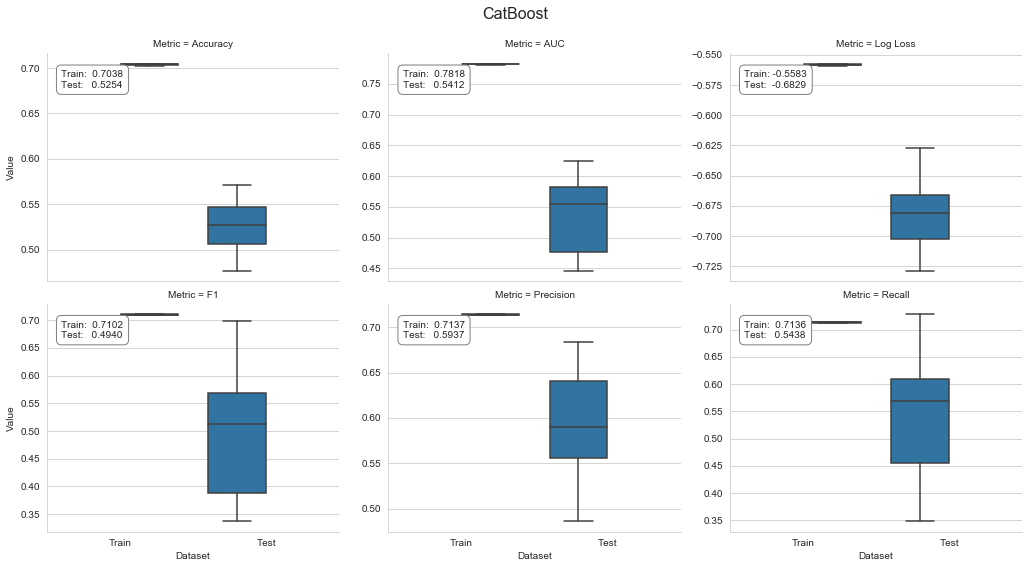

In [155]:
plot_result(cat_gpu_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

## Compare Results

In [164]:
results = {'Baseline': dummy_result,
           'Random Forest': rf_result,
           'AdaBoost': ada_result,
           'Gradient Booster': gb_result,
           'XGBoost': xbg_result,
           'LightGBM Dummies': lgb_dummy_result,
           'LightGBM Factors': lgb_factor_result,
           'CatBoost': cat_result,
          'CatBoost GPU': cat_gpu_result}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat([df, result.groupby(['Metric', 'Dataset']
                                       ).Value.mean().unstack()['Test'].to_frame(model)], axis=1)

df.T.sort_values('AUC', ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
CatBoost GPU,0.541172,0.525371,0.493970,-0.682886,0.593653,0.543762
Gradient Booster,0.537317,0.504663,0.464947,-0.684333,0.548900,0.576597
LightGBM Factors,0.536973,0.516648,0.392878,-0.724204,0.561619,0.491467
Random Forest,0.535827,0.517894,0.511238,-0.688548,0.569978,0.545110
AdaBoost,0.534758,0.506772,0.466868,-0.692840,0.547130,0.575898
CatBoost,0.532007,0.520849,0.486647,-0.709081,0.578961,0.514970
XGBoost,0.526489,0.502422,0.390695,-0.704178,0.567957,0.500299
LightGBM Dummies,0.525707,0.511645,0.429873,-0.705478,0.569996,0.504142
Baseline,0.499775,0.499775,0.512867,-17.204103,0.545199,0.501896


In [167]:
algo_dict = dict(zip(['dummy_clf', 'random_forest', 'adaboost', 'sklearn_gbm', 'xgboost', 'lgb_factors', 'lgb_dummies', 'catboost', 'catboost_gpu'],
                     ['Baseline', 'Random Forest', 'AdaBoost', 'Gradient Booster', 'XGBoost', 'LightGBM Dummies', 'LightGBM Factors', 'CatBoost', 'CatBoost GPU']))

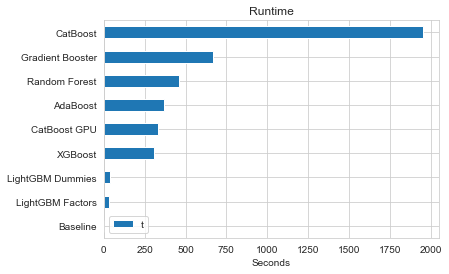

In [168]:
r = pd.Series(run_time).to_frame('t')
r.index = r.index.to_series().map(algo_dict)
r.to_csv('runtime.csv')
ax = r.sort_values('t').plot.barh(title='Runtime')
ax.set_xlabel('Seconds');

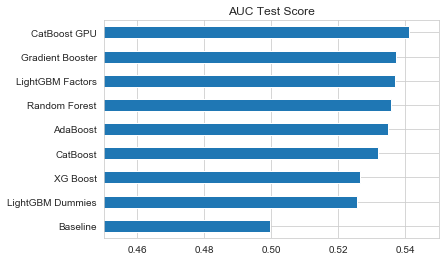

In [159]:
df.T['AUC'].sort_values().plot.barh(title='AUC Test Score', xlim=(.45, .55));

In [160]:
df.head()

,Baseline,Random Forest,AdaBoost,Gradient Booster,XG Boost,LightGBM Dummies,LightGBM Factors,CatBoost,CatBoost GPU
Metric,,,,,,,,,
AUC,0.499775,0.535827,0.534758,0.537317,0.526489,0.525707,0.536973,0.532007,0.541172
Accuracy,0.499775,0.517894,0.506772,0.504663,0.502422,0.511645,0.516648,0.520849,0.525371
F1,0.512867,0.511238,0.466868,0.464947,0.390695,0.429873,0.392878,0.486647,0.493970
Log Loss,-17.204103,-0.688548,-0.692840,-0.684333,-0.704178,-0.705478,-0.724204,-0.709081,-0.682886
Precision,0.545199,0.569978,0.547130,0.548900,0.567957,0.569996,0.561619,0.578961,0.593653


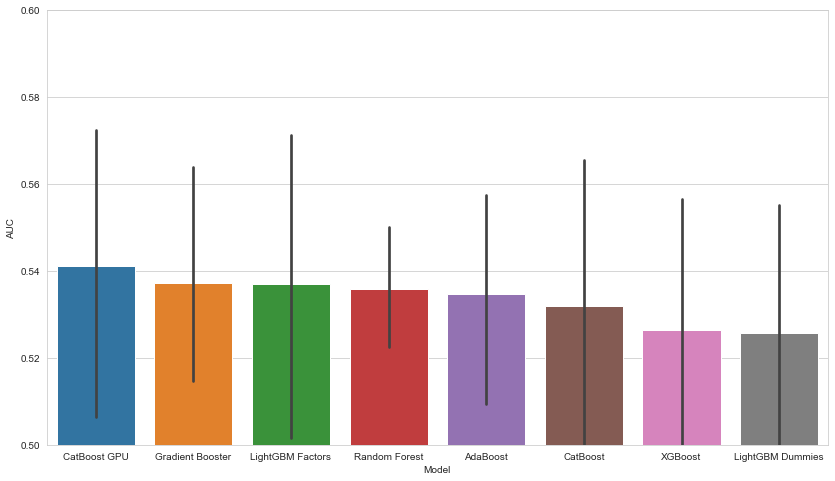

In [169]:
fig, ax = plt.subplots(figsize=(14, 8))
auc = pd.concat([v.loc[(v.Dataset=='Test') & (v.Metric=='AUC'), 'Value'].to_frame('AUC').assign(Model=k) 
                 for k, v in results.items()])
auc = auc[auc.Model != 'Baseline']
sns.barplot(x='Model', y='AUC', data=auc, order=df.T.drop('Baseline')['AUC'].sort_values(ascending=False).index, ax=ax)
ax.set_ylim(.5, .6);

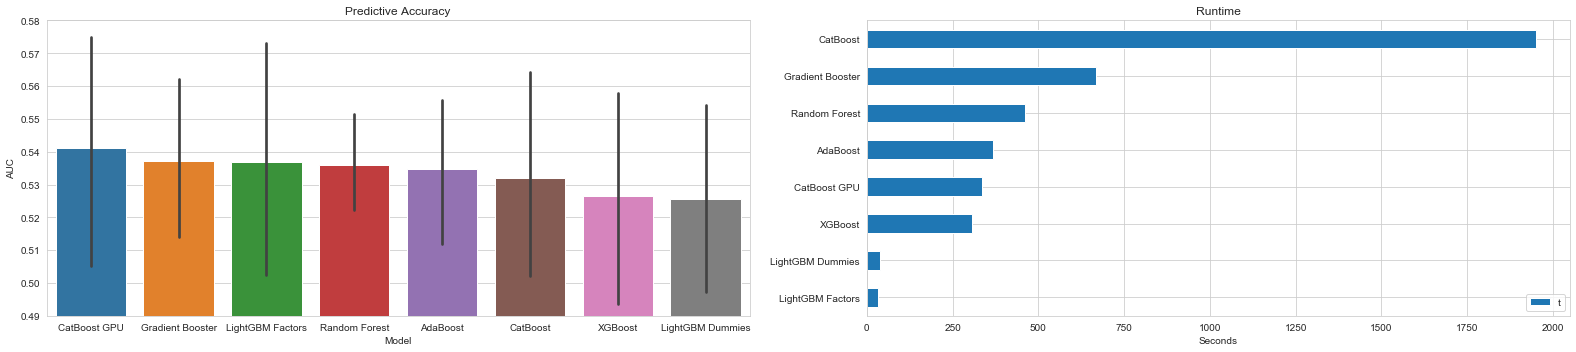

In [180]:
fig, axes = plt.subplots(figsize=(22, 5), ncols=2)
sns.barplot(x='Model', y='AUC', data=auc, order=df.T.drop('Baseline')['AUC'].sort_values(ascending=False).index, ax=axes[0])
axes[0].set_ylim(.49, .58)
axes[0].set_title('Predictive Accuracy')

r.drop('Baseline').sort_values('t').plot.barh(title='Runtime', ax=axes[1])
axes[1].set_xlabel('Seconds')
fig.tight_layout()
fig.savefig('figures/algo_comparison', dpi=300);